In [1]:
import pandas as pd

pd.set_option("display.precision", 3)
import os
import warnings

warnings.filterwarnings("ignore")
from sklearn.cluster import SpectralClustering
from mvlearn.cluster import MultiviewKMeans
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import sys
import math
import seaborn as sns

sns.set_style("white")
from ConsensusClusteringMultiView import ConsensusCluster
import scipy.stats as sps
import copy
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.lines as mlines
from sklearn.cluster import DBSCAN
from pathlib import Path
from random import shuffle
import scipy.stats as stats
from IPython.display import display

In [68]:
def cal_F_stat(data):
    SSB = (
        ((data.groupby("cluster").mean() - data.drop("cluster", 1).mean()) ** 2).T
        * data.groupby("cluster").size().values
    ).sum(1)

    SSW = []
    assert len(data["cluster"].unique()) == 2
    for k in sorted(data["cluster"].unique()):
        cluster = data[data["cluster"] == k].drop("cluster", 1)
        diff = (cluster - data.groupby("cluster").mean().loc[k]) ** 2
        SSW.append(diff)
    SSW = pd.concat(SSW).sum()
    coef = (len(data) - len(data["cluster"].unique())) / (
        len(data["cluster"].unique()) - 1
    )
    F_stat = (coef * (SSB / SSW)).sort_values(ascending=False)
    return F_stat


def get_ovr_F_stat(data, num_var):
    F_stat_true = cal_F_stat(data)
    all_F_stat = []
    n_test = 19 * num_var
    for i in tqdm(range(n_test)):
        data_run = data.copy()
        rs = np.random.RandomState(i)
        random_assignment = data_run["cluster"].tolist()
        rs.shuffle(random_assignment)
        data_run["cluster"] = random_assignment
        F_stat = cal_F_stat(data_run)
        all_F_stat.append(F_stat)

    all_F_stat = pd.concat(all_F_stat, 1)
    all_F_stat.columns = ["random {}".format(i + 1) for i in range(all_F_stat.shape[1])]
    all_F_stat["true"] = F_stat_true
    return all_F_stat

def plot_top(data, stats, save_path, name):
    target_var = stats.index.tolist()
    plt.figure(figsize=(30, 10))
    target_cluster = data["cluster"].unique()
    num_fisher = stats[stats['F_stat'] == 1e8].shape[0]
    for i, var in enumerate(target_var):
        f_value, p_value = stat.loc[var, [ 'F_stat', 'p-value']].tolist()
        
        if i < num_fisher:
            plt.subplot(2, 5, i + 1)
            
            assert f_value == 1e8
            j = 0
            for k in target_cluster:
                try:
                    k = int(k)
                except:
                    pass
                cluster = data[data["cluster"] == k]
                plt.bar(
                    j, 
                    (cluster[var] == 1).sum() / len(cluster), width=0.3,
                    label="cluster {}, size {}".format(k, len(cluster)),
                )
                j += 1
            plt.xticks(np.arange(j), target_cluster)
            plt.legend()
            plt.ylim(0, 1)
            plt.title('{}, p: {:.3e}'.format(var, p_value), fontsize=15)
        else:
            i = max(5, i)
            plt.subplot(2, 5, i + 1)
            assert f_value != 1e8
            for k in target_cluster:
                try:
                    k = int(k)
                except:
                    pass
                cluster = data[data["cluster"] == k]
                plt.hist(
                    cluster[var],
                    bins=25,
                    alpha=0.5,
                    density=True,
                    histtype="stepfilled",
                    label="cluster {}, size {}".format(k, len(cluster)),
                )
            plt.legend()
            plt.title('{}, p: {:.3e}, f: {:.3f}'.format(var, p_value, f_value), fontsize=15)

    plt.suptitle(name, fontsize=25)

    plt.savefig(
        "{}/{}.png".format(save_path, name), dpi=300,
    )
    plt.show()
    

In [56]:
def plot_top_fisher(data, stats, save_path, name):
    target_var = stats.index.tolist()
    plt.figure(figsize=(30, 5))
    target_cluster = data["cluster"].unique()
    num_fisher = stats[stats['F_stat'] == 1e8].shape[0]
    for i, var in enumerate(target_var):
        f_value, p_value = stat.loc[var, [ 'F_stat', 'p-value']].tolist()
        plt.subplot(2, 5, i + 1)
        assert f_value == 1e8
        j = 0
        for k in target_cluster:
            try:
                k = int(k)
            except:
                pass
            cluster = data[data["cluster"] == k]
            plt.bar(
                j, 
                (cluster[var] == 1).sum() / len(cluster), width=0.3,
                label="cluster {}, size {}".format(k, len(cluster)),
            )
            j += 1
            plt.xticks(np.arange(j), target_cluster)
            plt.legend()
            plt.ylim(0, 1)
            plt.title('{}, p: {:.3e}'.format(var, p_value), fontsize=15)
        plt.suptitle(name, fontsize=25)
        plt.savefig(
            "{}/{}.png".format(save_path, name), dpi=300,
        )
        plt.show()

In [3]:
data_path = "data/"
score_path = "{}/ClusteringResults/".format(data_path)
KCC_path = "{}/KCC/".format(data_path)
f_stat_path = '{}/F_stat&Fisher_OVR/'.format(data_path)
top_feature_plot_path = '{}/TopFeaturesOVR_plots/'.format(data_path)

In [4]:
proteome_view = pd.read_csv(
    "{}/ProteomeViewMICEimputed.csv".format(data_path), index_col=0
)
contextual_view = pd.read_csv(
    "{}/ContextualViewZeroImputed.csv".format(data_path), index_col=0
)
physio_view = pd.read_csv(
    "{}/PhysioViewMICEimputed.csv".format(data_path), index_col=0
)
contextual_view_PCs = pd.read_csv(
    "{}/ContextualViewStandardized.csv".format(data_path), index_col=0
)

contextual_view_PCs = contextual_view_PCs.drop('fio2.high', 1)
npx = pd.read_csv("../olinks/20191053_Giannoni_NPX.csv")
npx.set_index("Panel", inplace=True)

uniport = {}
for k, p in enumerate(npx.columns):
    uniport[p] = npx.iloc[:, k]["Uniprot ID"]
uniprot_col = []
for col in proteome_view.columns:
    uniprot_col.append(uniport[col])

proteome_view.columns = uniprot_col
clinical_view = pd.concat([physio_view, contextual_view_PCs, contextual_view], 1)
clinical_view = clinical_view.loc[
    :,
    ~clinical_view.columns.isin(
        ["pupils", "crp.high", "neonate", "abx.change.cfz", "abx.change.ery"]
    ),
]
all_features = pd.concat([clinical_view, proteome_view], 1)
binary_cols = [col for col in all_features.columns if len(all_features[col].unique()) == 2]
binary_cols.remove('pelod.ren')
continous_cols = [col for col in all_features.columns if len(all_features[col].unique()) > 2] + ['pelod.ren']
all_features = all_features.loc[all_features.index.isin(contextual_view_PCs.index)]

In [5]:
nb_continous_vars = len(continous_cols)
nb_binary_vars = len(binary_cols)
total_vars = nb_continous_vars + nb_binary_vars 


In [70]:
configs = [
    ["clinical", 4, "DBSCAN"],
    ["contextual", 6, "DBSCAN"],
    ["physio", 4, "ConsensusKMeans"],
    ["proteome", 5, "DBSCAN"]
]

#configs = [["physio", 4, "ConsensusKMeans"]]

# OVR Fisher exact

In [ ]:
for i in range(len(configs)):
    
    view, KCC_space, method = configs[i]

    assignment = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    print(assignment.head())
    if method == "DBSCAN":
        assignment["assignment"] = assignment["assignment"] + 1
        assignment = assignment[assignment["assignment"] != 0]
    assignment["assignment"] = assignment["assignment"].astype(int)
    data = all_features[binary_cols].copy()
    data["cluster"] = assignment["assignment"]
    data = data[data["cluster"].notnull()]
    
    num_cluster = len(data["cluster"].unique())
    all_clusters = sorted(data["cluster"].unique())
    
    for i in all_clusters:
        all_p_val = pd.Series(index=binary_cols)
        i = int(i)
        data_ovr = data.copy()
        data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = i + 1
        save_name = "{}_{}_KCC_{}_FisherExact_cluster_{}vsR.csv".format(
                    method, view, KCC_space, i
                )
        
        for col in binary_cols:
            try:
                contingency_table = pd.crosstab(
                    data_ovr[col], data_ovr["cluster"]
                )
                p_val = stats.fisher_exact(contingency_table)[1]
                all_p_val.loc[col] = p_val
            except:
                pass
        all_p_val.to_csv("{}/{}".format(f_stat_path, save_name))


In [ ]:
assignment = pd.read_csv(
        "{}/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv".format(data_path),
        index_col=0,
    )
data = all_features[binary_cols].copy()
data["cluster"] = assignment["assignment"]
data = data[data["cluster"].notnull()]
num_cluster = len(data["cluster"].unique())
all_clusters = sorted(data["cluster"].unique())
for i in all_clusters:
        all_p_val = pd.Series(index=binary_cols)
        i = int(i)
        data_ovr = data.copy()
        data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = i + 1
        save_name = "MV_FisherExact_cluster_{}vsR.csv".format(i)
        for col in binary_cols:
            try:
                contingency_table = pd.crosstab(
                    data_ovr[col], data_ovr["cluster"]
                )
                p_val = stats.fisher_exact(contingency_table)[1]
                all_p_val.loc[col] = p_val
            except:
                pass
        all_p_val.to_csv("{}/{}".format(f_stat_path, save_name))

# OVR F-stat

In [ ]:
for i in range(len(configs)):
    view, KCC_space, method = configs[i]
    assignment = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    if method == "DBSCAN":
        assignment["assignment"] = assignment["assignment"] + 1
        assignment = assignment[assignment["assignment"] != 0]
    
    data = all_features[continous_cols].copy()
    data["cluster"] = assignment["assignment"]
    data = data[data["cluster"].notnull()]
    num_cluster = len(data["cluster"].unique())
    all_clusters = sorted(data["cluster"].unique())
    print(data.shape)
    
    for i in all_clusters:
        i =  int(i)
        data_ovr = data.copy()
        data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = i + 1
        save_name = "{}_{}_KCC_{}_F_stat_cluster_{}vsR.csv".format(
                        method, view, KCC_space, i
                    )
        all_F_stat = get_ovr_F_stat(data_ovr, total_vars)
        F_stat_true = all_F_stat["true"]
        F_stat_true_pvalue = (
            all_F_stat.rank(axis=1, ascending=False)["true"]
            / all_F_stat.shape[1]
        )
        F_stat_true = pd.concat([F_stat_true, F_stat_true_pvalue], 1)
        F_stat_true.columns = ["F_stat", "p-value"]

        F_stat_true.to_csv("{}/{}".format(f_stat_path, save_name))

In [ ]:
assignment = pd.read_csv(
        "{}/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv".format(data_path),
        index_col=0,
    )
data = all_features[continous_cols].copy()
data["cluster"] = assignment["assignment"]
data = data[data["cluster"].notnull()]
num_cluster = len(data["cluster"].unique())
all_clusters = sorted(data["cluster"].unique())
for i in all_clusters:
    i =  int(i)
    data_ovr = data.copy()
    data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = i + 1
    save_name = "MV_F_stat_cluster_{}vsR.csv".format(i)
    all_F_stat = get_ovr_F_stat(data_ovr, total_vars)
    F_stat_true = all_F_stat["true"]
    F_stat_true_pvalue = (
        all_F_stat.rank(axis=1, ascending=False)["true"]
        / all_F_stat.shape[1]
    )
    F_stat_true = pd.concat([F_stat_true, F_stat_true_pvalue], 1)
    F_stat_true.columns = ["F_stat", "p-value"]

    F_stat_true.to_csv("{}/{}".format(f_stat_path, save_name))

# plot top features

(341, 543)


,p-value,F_stat
focus_uti,6.466e-18,1.000e+08
cahai_los.ca,7.880e-15,1.000e+08
patho_sagalactiae,6.959e-12,1.000e+08
patho_ecoli,6.340e-06,1.000e+08
focus_clabsi,8.123e-06,1.000e+08
Q8WTU2,9.710e-05,1.110e+02
infections_PC_2,9.710e-05,1.035e+02
Q8IZP9,9.710e-05,8.642e+01
lymph.low,9.710e-05,6.530e+01
age.at.bc,9.710e-05,5.256e+01


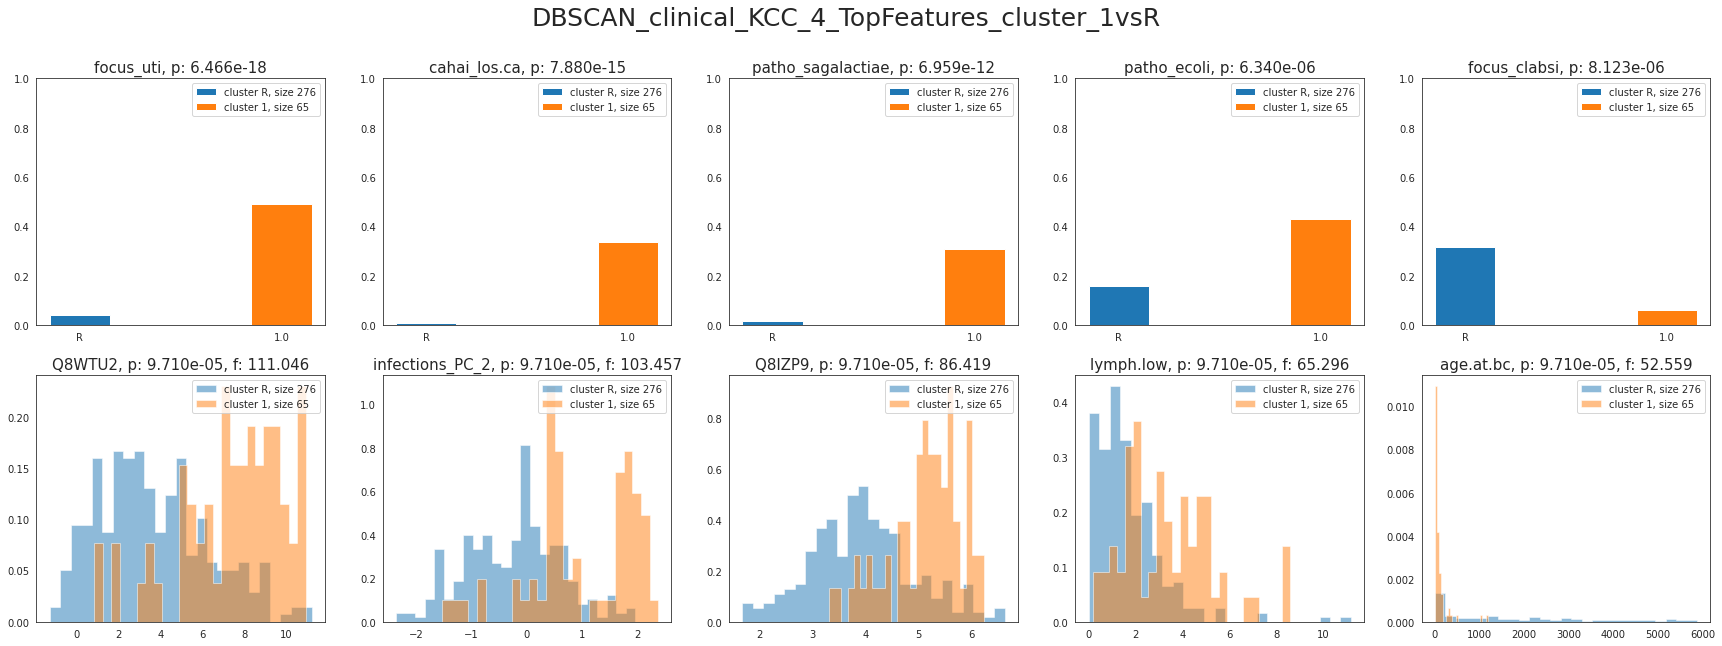

,p-value,F_stat
cate_healthy,2.491e-23,1.000e+08
cate_neonate,4.935e-16,1.000e+08
cons05.resp,4.011e-14,1.000e+08
cahai_ca,3.577e-11,1.000e+08
focus_osteoarticular,2.552e-10,1.000e+08
Q6UXB4,9.710e-05,1.649e+02
Q6DN72,9.710e-05,1.481e+02
hr.high,9.710e-05,1.455e+02
age.at.bc,9.710e-05,1.376e+02
Q13241,9.710e-05,1.344e+02


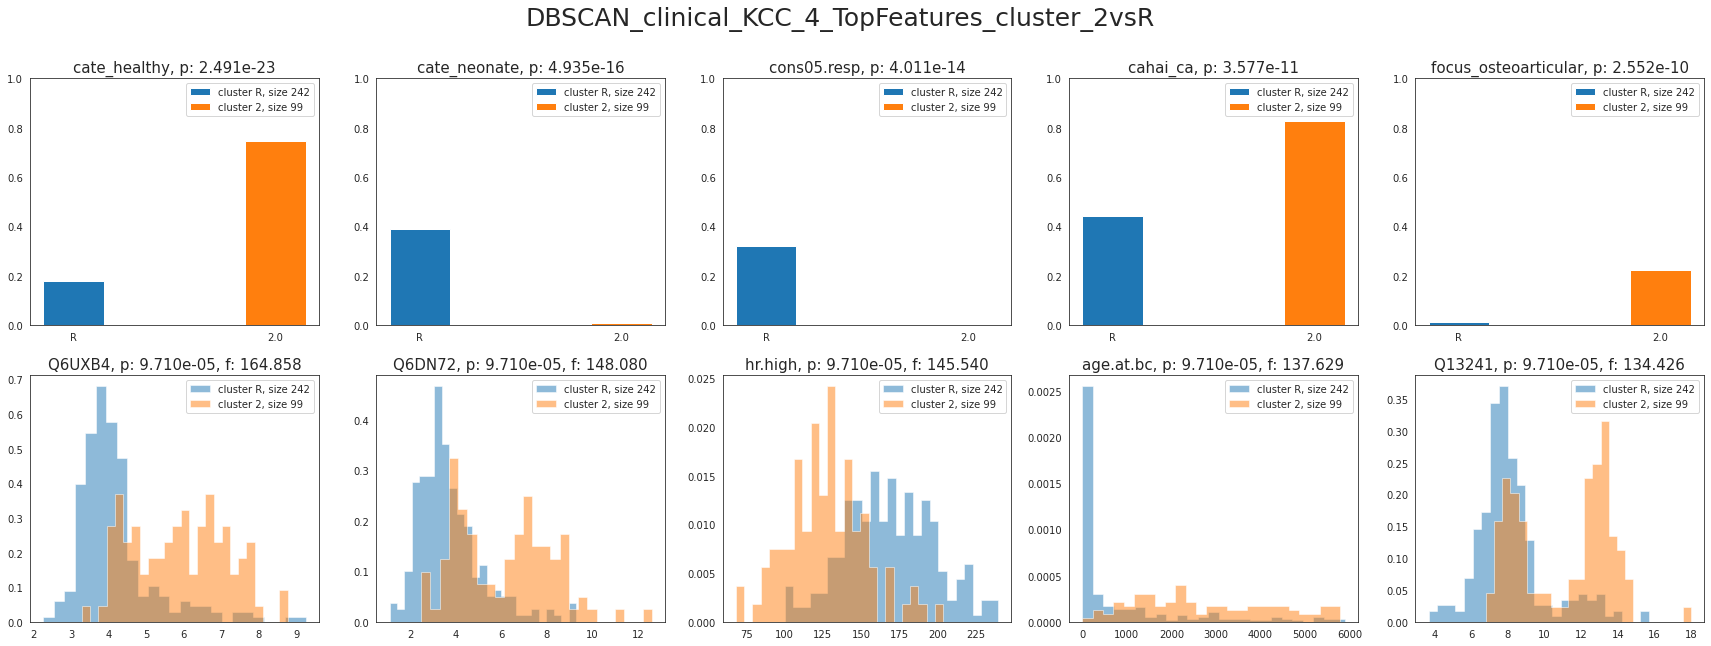

,p-value,F_stat
ccc.onco,1.482e-51,1.000e+08
cate_comorbidity,1.604e-24,1.000e+08
cons05.hem,2.494e-21,1.000e+08
cate_healthy,2.172e-11,1.000e+08
focus_clabsi,3.118e-08,1.000e+08
pelod.hem,9.710e-05,3.065e+02
P19878,9.710e-05,2.861e+02
Q96LA6,9.710e-05,2.478e+02
P14317,9.710e-05,2.441e+02
P12724,9.710e-05,2.434e+02


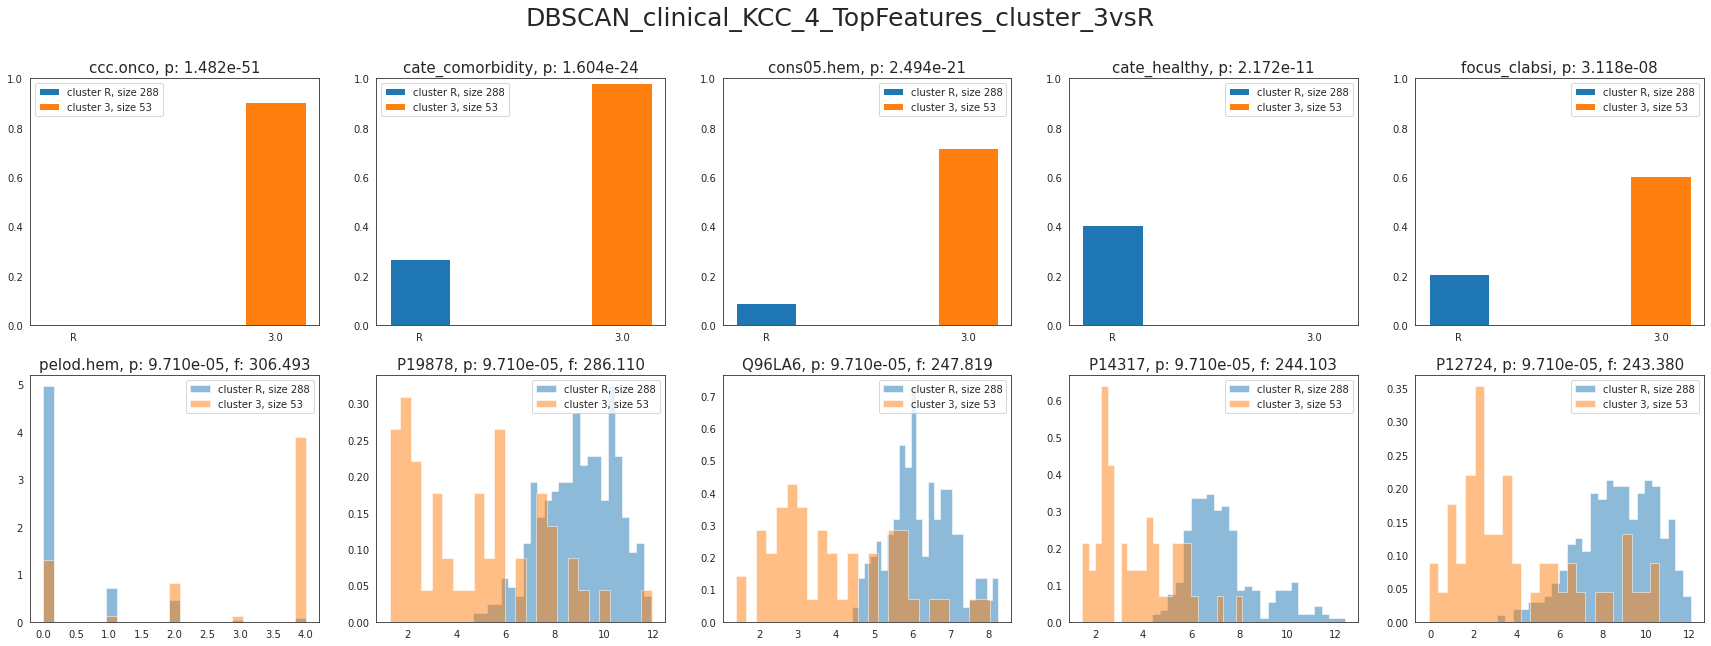

,p-value,F_stat
cahai_los.hai,5.990e-42,1.000e+08
cate_neonate,1.253e-33,1.000e+08
ccc.neo,7.580e-28,1.000e+08
cahai_ca,3.035e-22,1.000e+08
cons05.resp,6.806e-12,1.000e+08
Q01973,9.710e-05,1.357e+02
Q13308,9.710e-05,1.351e+02
P28845,9.710e-05,1.259e+02
Q9H6B4,9.710e-05,1.254e+02
sbp.low,9.710e-05,1.122e+02


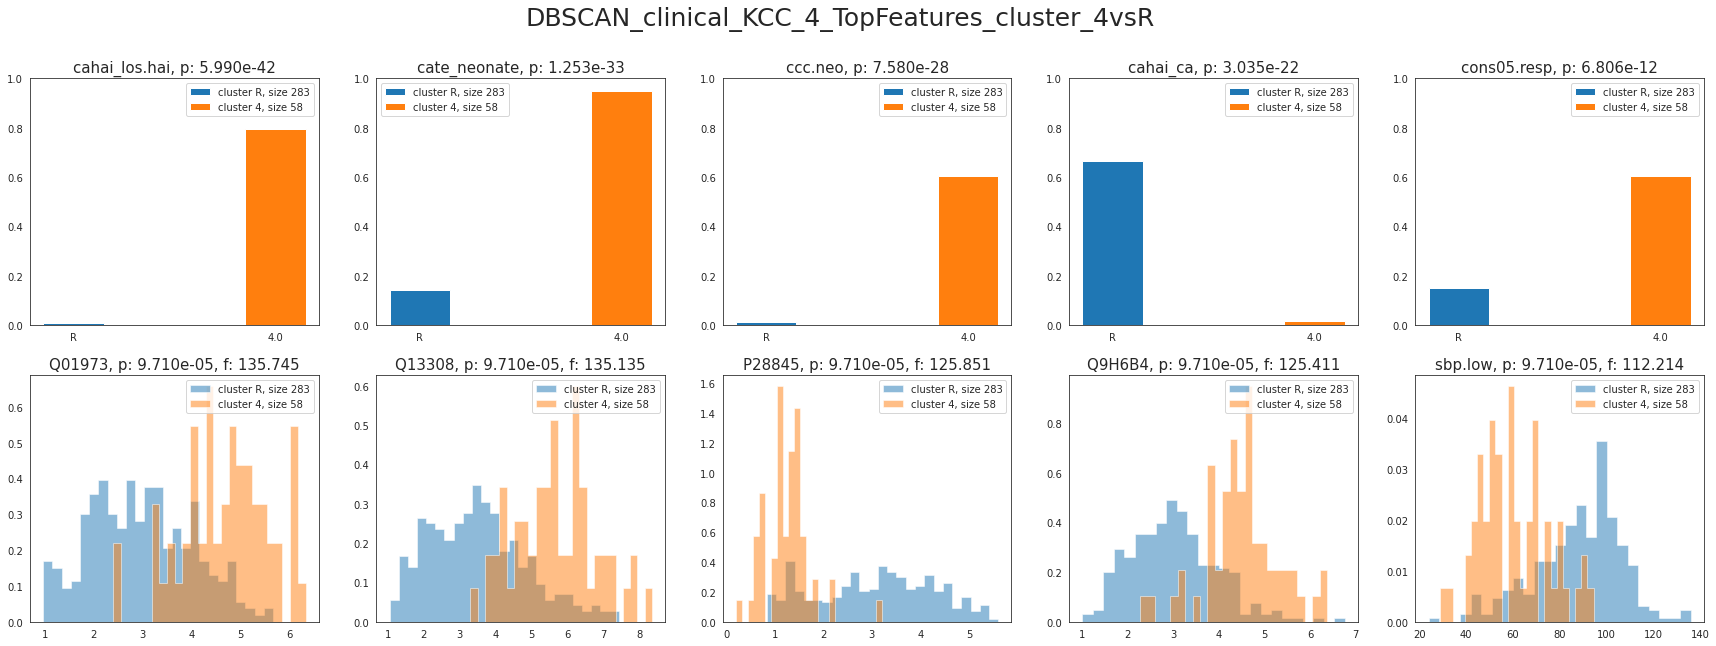

,p-value,F_stat
inotrope,1.216e-19,1.000e+08
iv,2.672e-17,1.000e+08
cons05.cvs,3.099e-15,1.000e+08
cons05.resp,5.345e-14,1.000e+08
cons05.cns,8.203e-13,1.000e+08
cons05.score,9.710e-05,1.409e+02
psofa.cvs,9.710e-05,1.265e+02
psofa.score,9.710e-05,1.211e+02
pelod.resp,9.710e-05,1.205e+02
psofa.cns,9.710e-05,1.135e+02


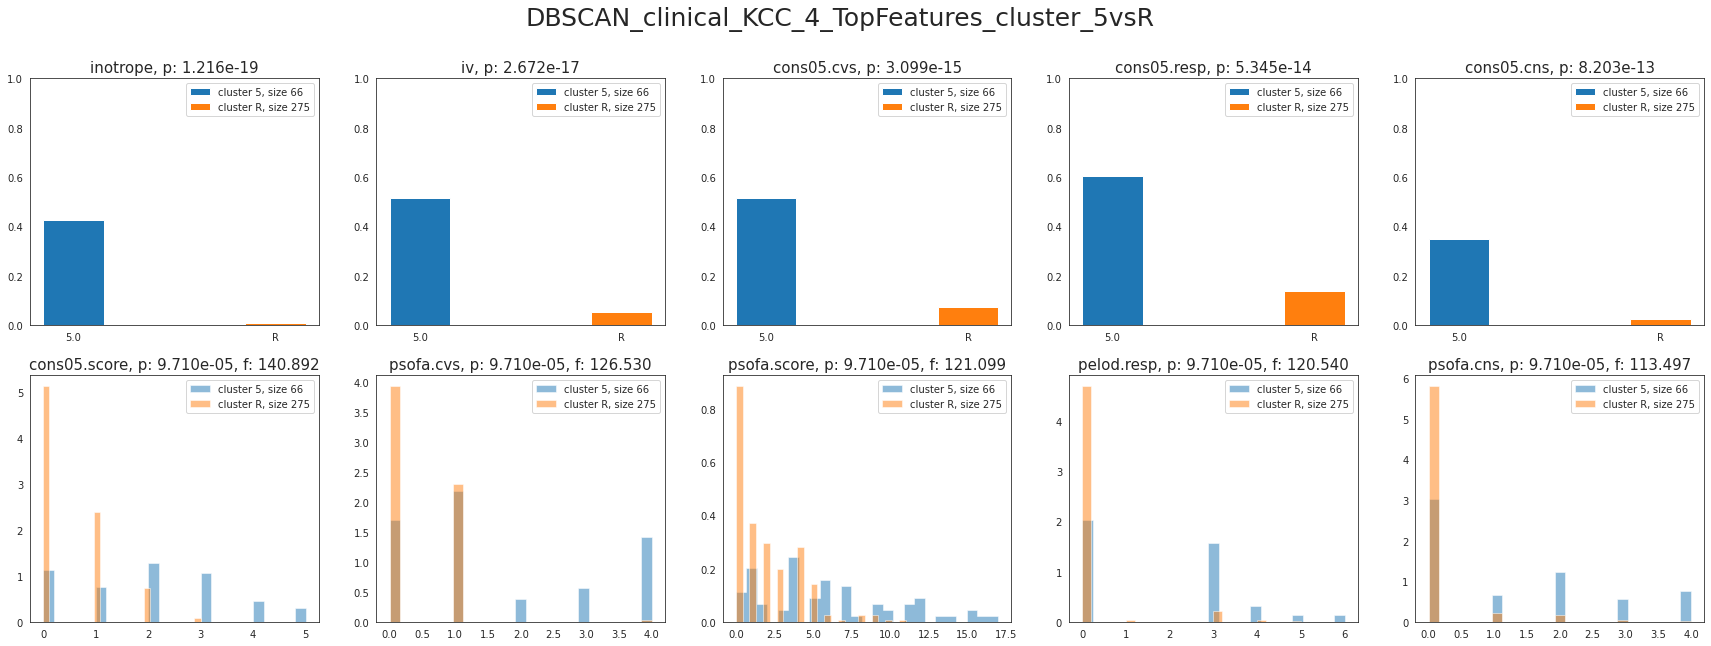

(346, 543)


,p-value,F_stat
cate_healthy,2.494e-33,1.000e+08
cahai_ca,4.471e-15,1.000e+08
patho_spneumoniae,1.493e-14,1.000e+08
cate_comorbidity,1.493e-12,1.000e+08
cate_neonate,6.282e-11,1.000e+08
context_PC_1,9.710e-05,1.323e+02
infections_PC_1,9.710e-05,9.277e+01
Q8IU57,9.710e-05,8.556e+01
P01732,9.710e-05,7.493e+01
Q99616,9.710e-05,7.302e+01


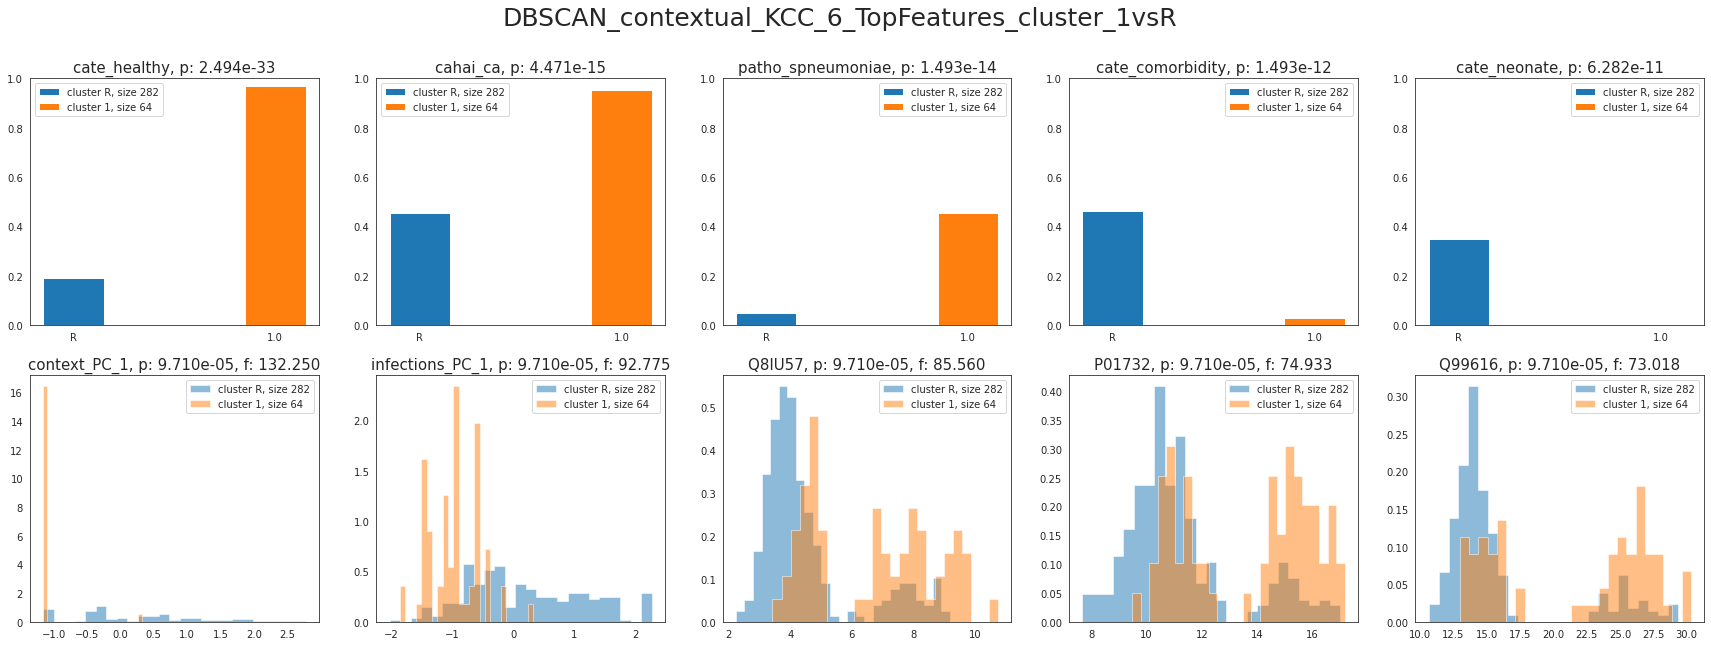

,p-value,F_stat
focus_osteoarticular,4.414e-36,1.000e+08
patho_saureus,1.175e-15,1.000e+08
cate_healthy,1.187e-08,1.000e+08
cate_comorbidity,3.912e-05,1.000e+08
focus_clabsi,1.875e-04,1.000e+08
infections_PC_2,9.710e-05,8.066e+01
Q6DN72,9.710e-05,6.471e+01
infections_PC_7,9.710e-05,6.407e+01
Q13241,9.710e-05,5.205e+01
P50591,9.710e-05,5.064e+01


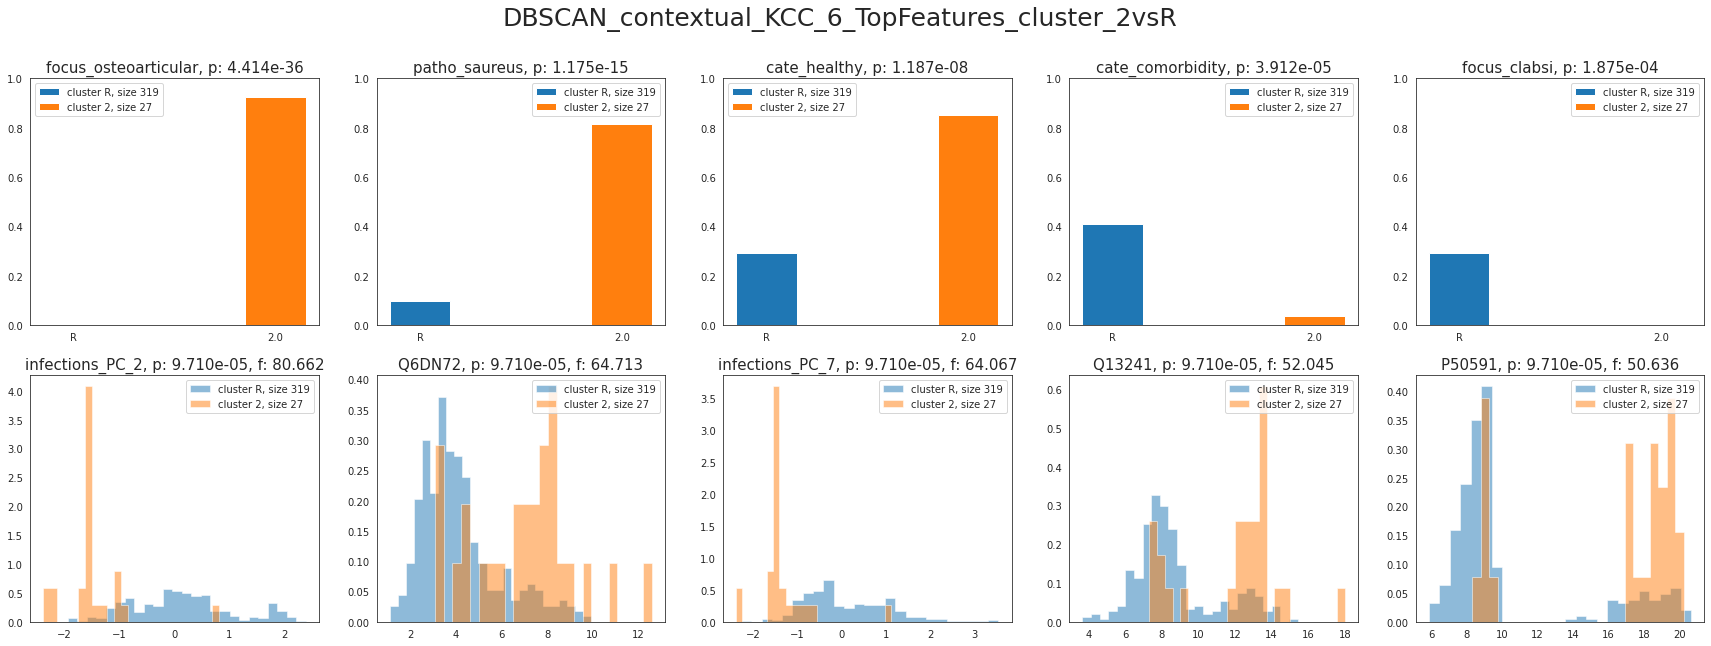

,p-value,F_stat
patho_sagalactiae,8.321e-30,1.000e+08
cahai_los.ca,9.743e-25,1.000e+08
cate_neonate,5.933e-16,1.000e+08
cate_comorbidity,6.595e-11,1.000e+08
cahai_ca,8.831e-08,1.000e+08
infections_PC_2,9.710e-05,1.835e+02
Q8WTU2,9.710e-05,9.925e+01
Q8IZP9,9.710e-05,7.253e+01
P22466,9.710e-05,4.922e+01
Q02246,9.710e-05,4.654e+01


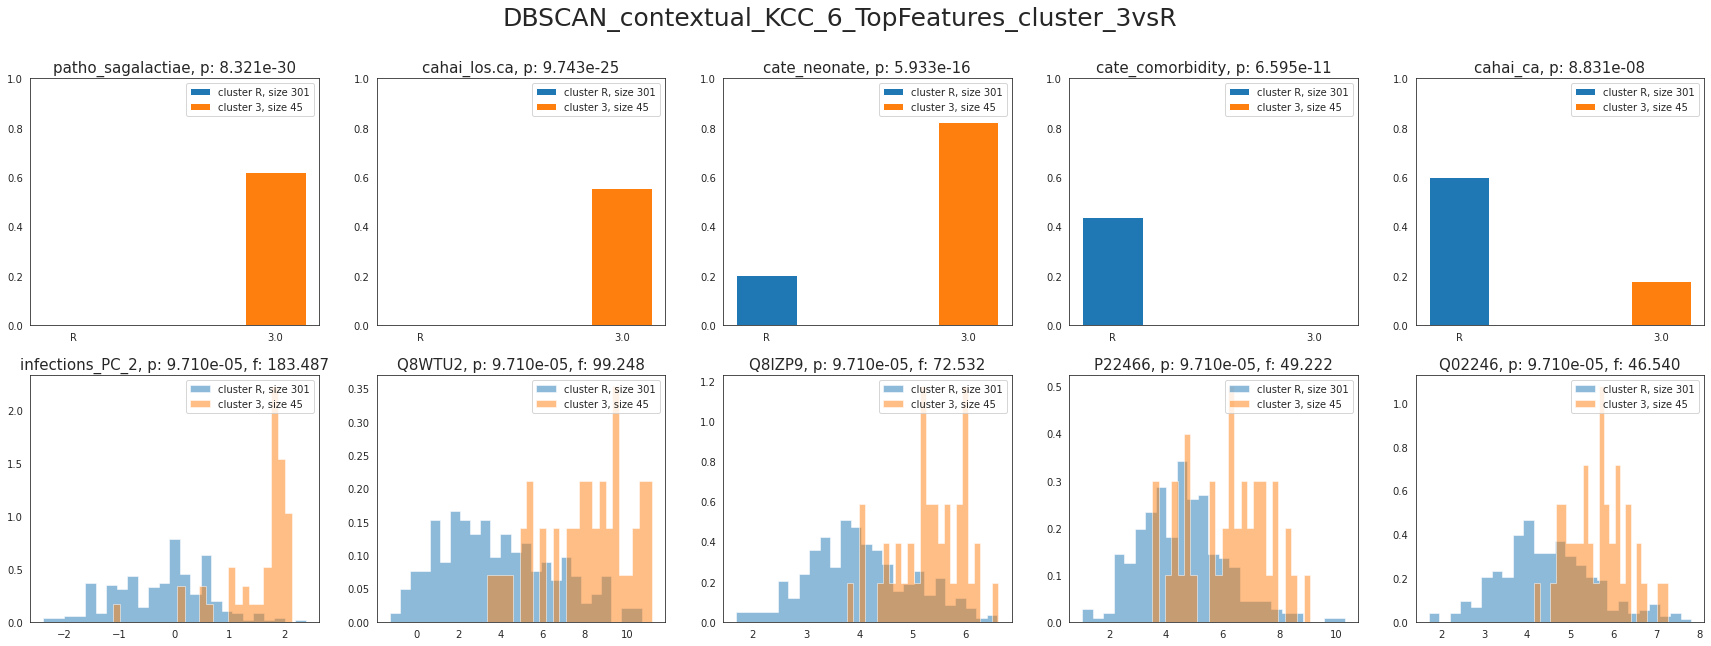

,p-value,F_stat
ccc.onco,1.927e-36,1.000e+08
cate_comorbidity,1.898e-30,1.000e+08
focus_clabsi,7.066e-13,1.000e+08
cate_healthy,1.523e-12,1.000e+08
cons05.hem,1.765e-12,1.000e+08
context_PC_2,9.710e-05,1.648e+02
P14317,9.710e-05,1.470e+02
pelod.hem,9.710e-05,1.231e+02
Q9UHF1,9.710e-05,1.143e+02
Q9UMR7,9.710e-05,1.132e+02


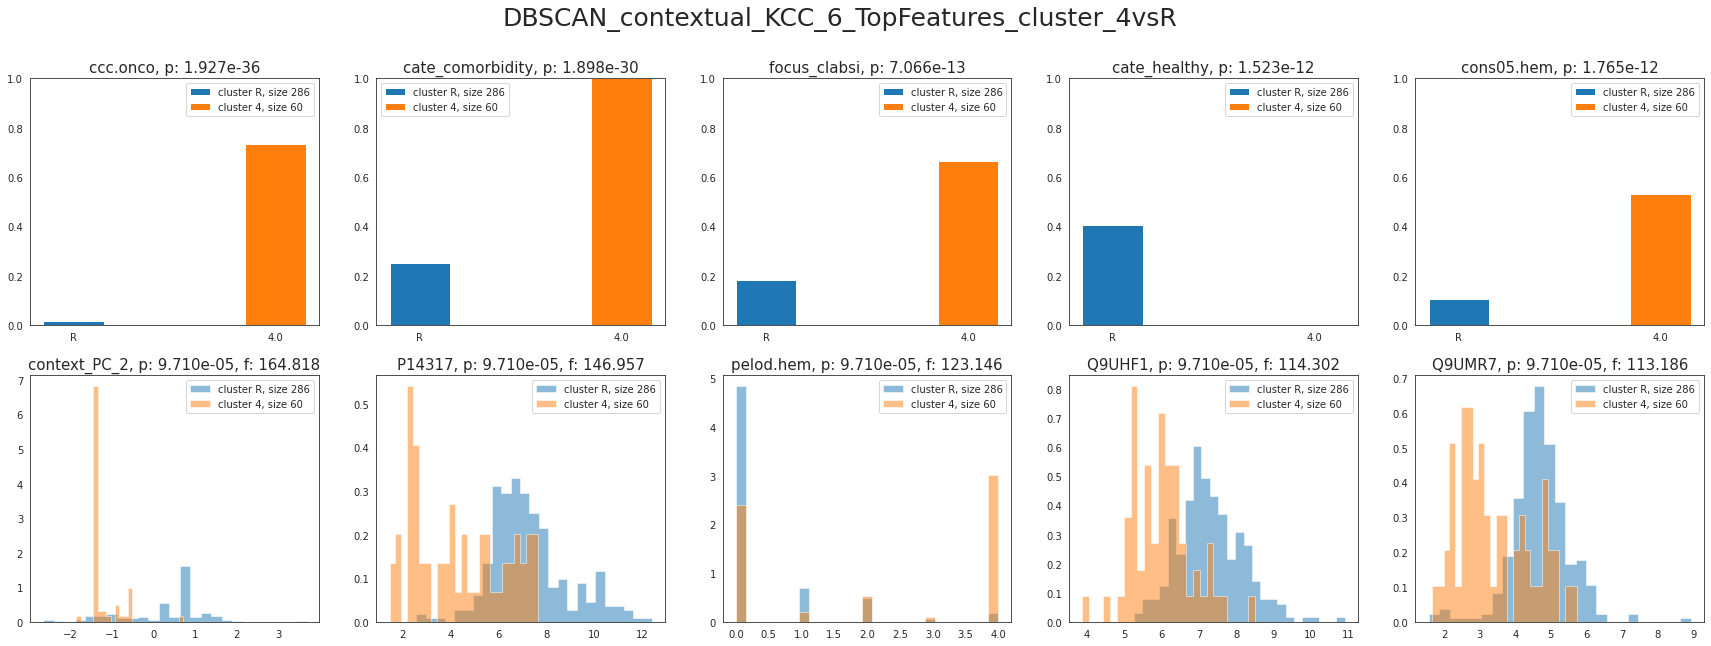

,p-value,F_stat
focus_abdominal,1.713e-13,1.000e+08
cate_comorbidity,1.037e-09,1.000e+08
eth_asian,5.346e-09,1.000e+08
cahai_hai,4.717e-07,1.000e+08
eth_caucasian,1.770e-06,1.000e+08
demographics_PC_2,9.710e-05,3.732e+01
demographics_PC_1,9.710e-05,3.717e+01
infections_PC_29,9.710e-05,3.689e+01
Q9NZQ7,9.710e-05,3.214e+01
Q15846,9.710e-05,2.909e+01


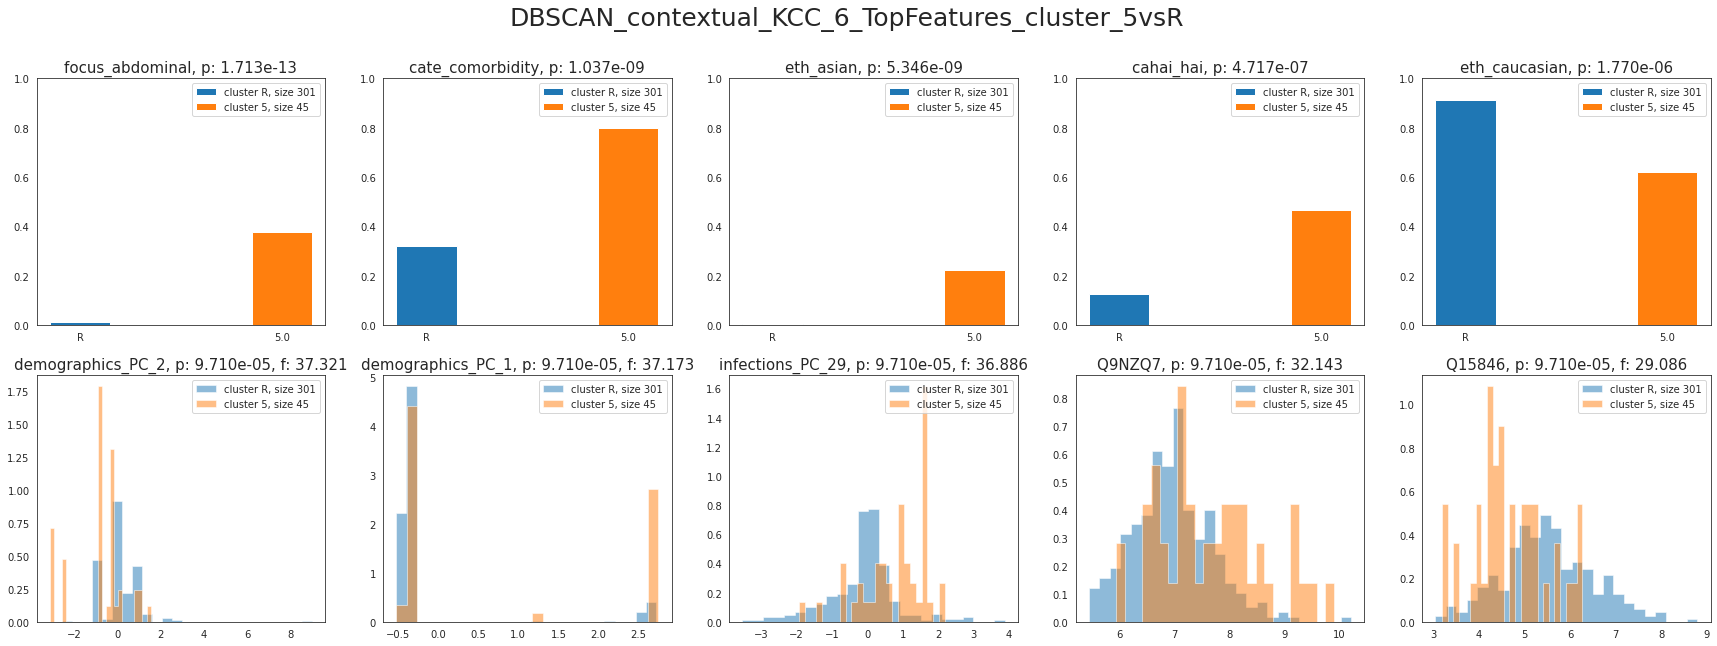

,p-value,F_stat
inotrope,1.008e-10,1.000e+08
ccc.cardio,7.140e-09,1.000e+08
cate_neonate,2.320e-08,1.000e+08
cons05.cvs,1.119e-07,1.000e+08
iv,8.787e-07,1.000e+08
context_PC_5,9.710e-05,7.314e+01
psofa.cvs,9.710e-05,5.786e+01
cons05.score,9.710e-05,5.165e+01
context_PC_8,9.710e-05,4.191e+01
context_PC_1,9.710e-05,4.144e+01


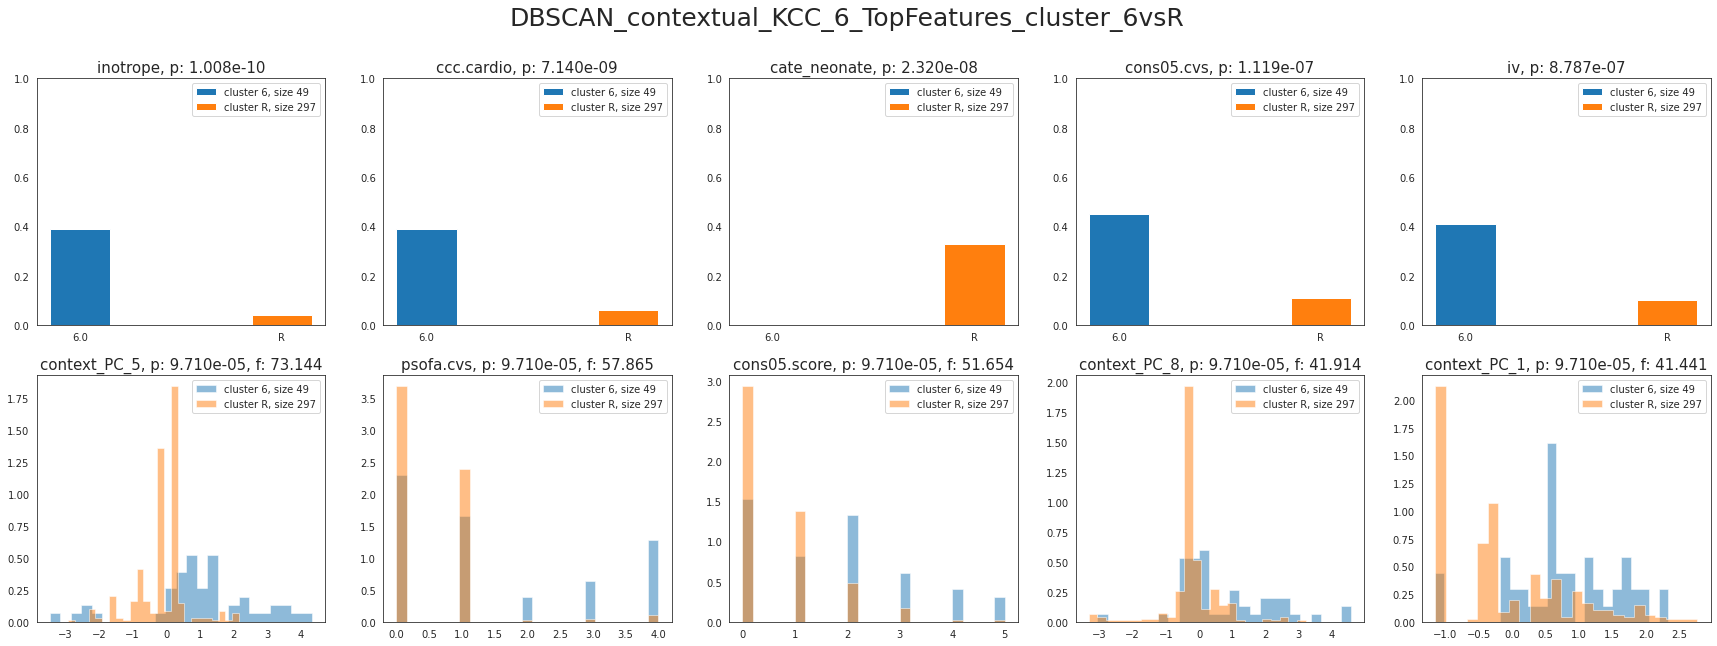

,p-value,F_stat
cahai_los.hai,7.699e-39,1.000e+08
cate_neonate,4.830e-38,1.000e+08
ccc.neo,6.629e-37,1.000e+08
cahai_ca,8.958e-23,1.000e+08
cons05.resp,3.538e-19,1.000e+08
sbp.low,9.710e-05,1.732e+02
Q9H6B4,9.710e-05,1.675e+02
Q13308,9.710e-05,1.599e+02
Q01973,9.710e-05,1.418e+02
P28845,9.710e-05,1.398e+02


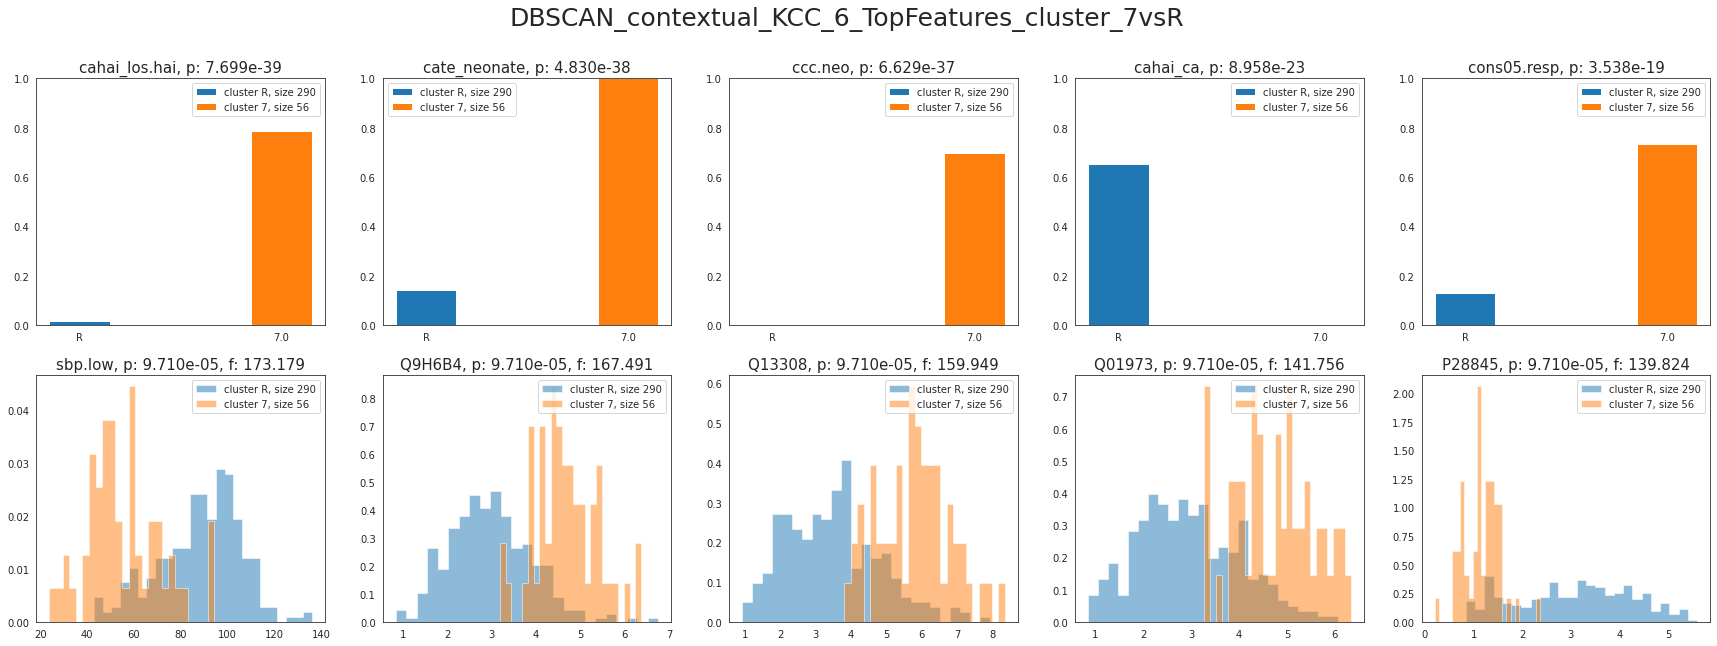

(358, 543)


,p-value,F_stat
focus_osteoarticular,3.325e-11,1.000e+08
cate_healthy,3.836e-10,1.000e+08
cate_neonate,5.703e-10,1.000e+08
cons05.resp,2.930e-08,1.000e+08
cahai_los.hai,5.609e-08,1.000e+08
hr.high,9.710e-05,2.043e+02
age.at.bc,9.710e-05,1.669e+02
rr.high,9.710e-05,1.194e+02
Q9P0M4,9.710e-05,8.248e+01
map.low,9.710e-05,7.927e+01


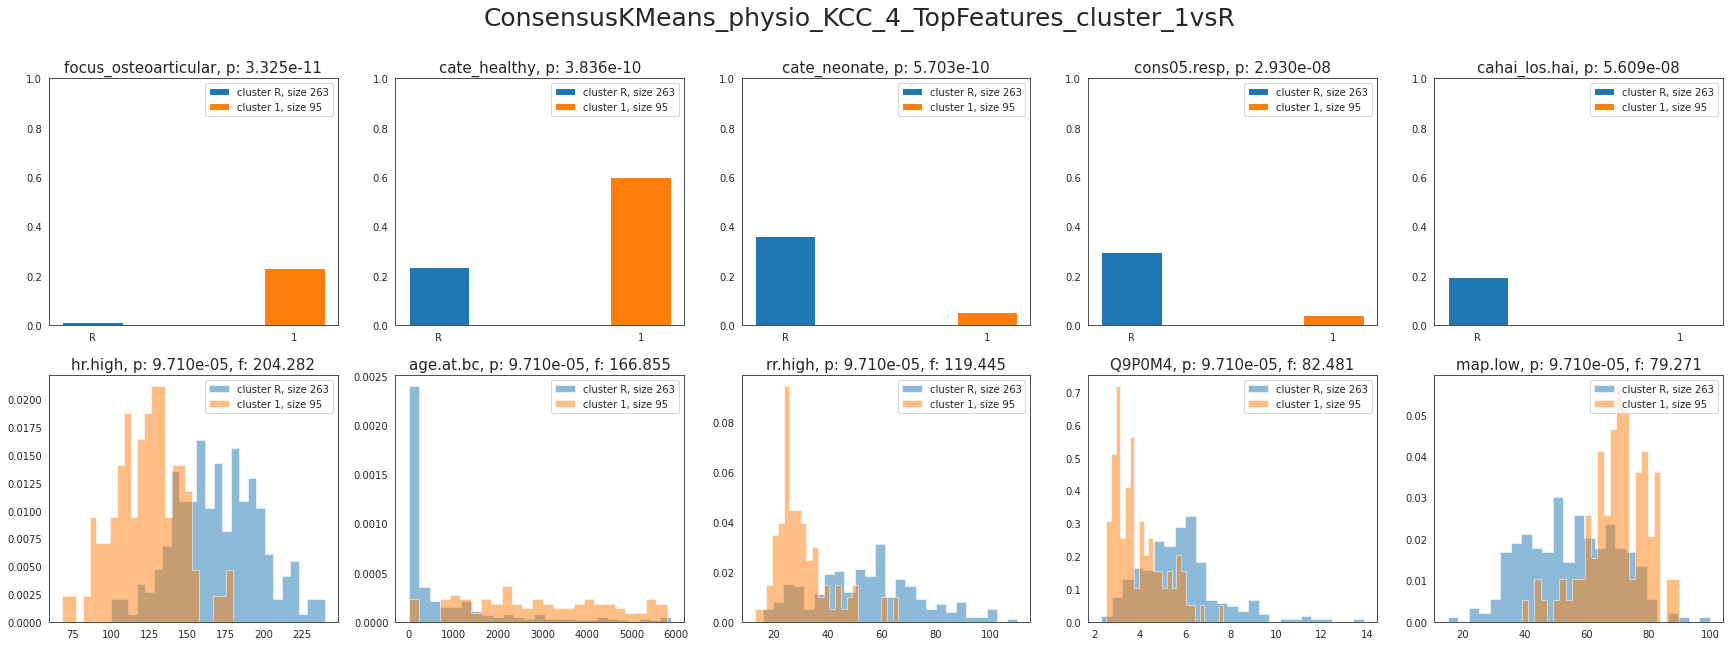

,p-value,F_stat
focus_uti,1.816e-10,1.000e+08
cons05.hem,3.746e-09,1.000e+08
ccc.onco,1.905e-05,1.000e+08
cons05.cvs,1.568e-04,1.000e+08
cahai_los.ca,1.823e-04,1.000e+08
lymph.low,9.710e-05,1.108e+02
platelets.low,9.710e-05,9.021e+01
age.at.bc,9.710e-05,6.354e+01
Q96LA6,9.710e-05,6.030e+01
hr.high,9.710e-05,4.691e+01


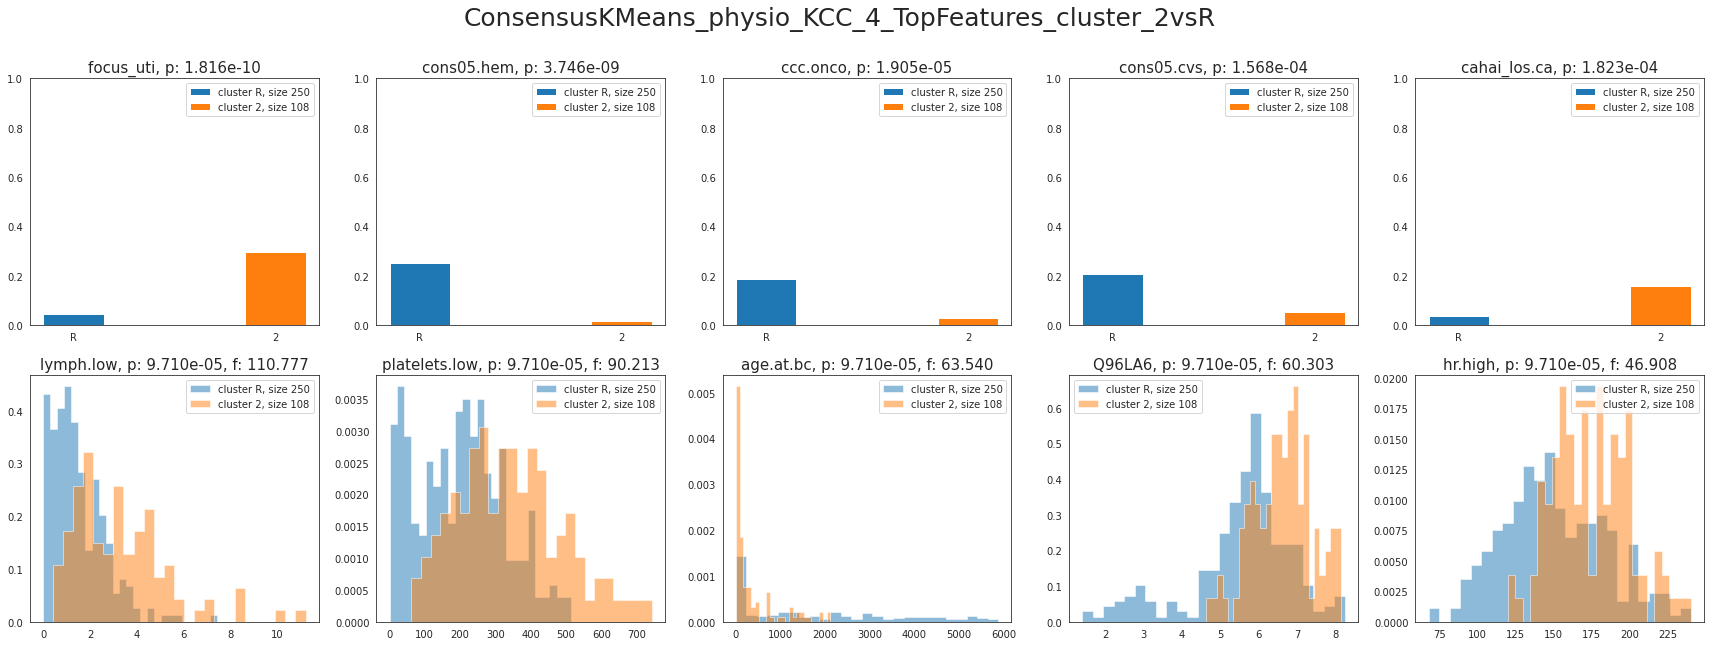

,p-value,F_stat
ccc.onco,7.501e-29,1.000e+08
cons05.hem,5.137e-18,1.000e+08
cate_comorbidity,8.832e-10,1.000e+08
cate_healthy,2.779e-06,1.000e+08
cons05.hep,6.619e-06,1.000e+08
pelod.hem,9.710e-05,2.813e+02
psofa.hem,9.710e-05,1.812e+02
Q96LA6,9.710e-05,1.356e+02
P12724,9.710e-05,1.268e+02
P19878,9.710e-05,1.254e+02


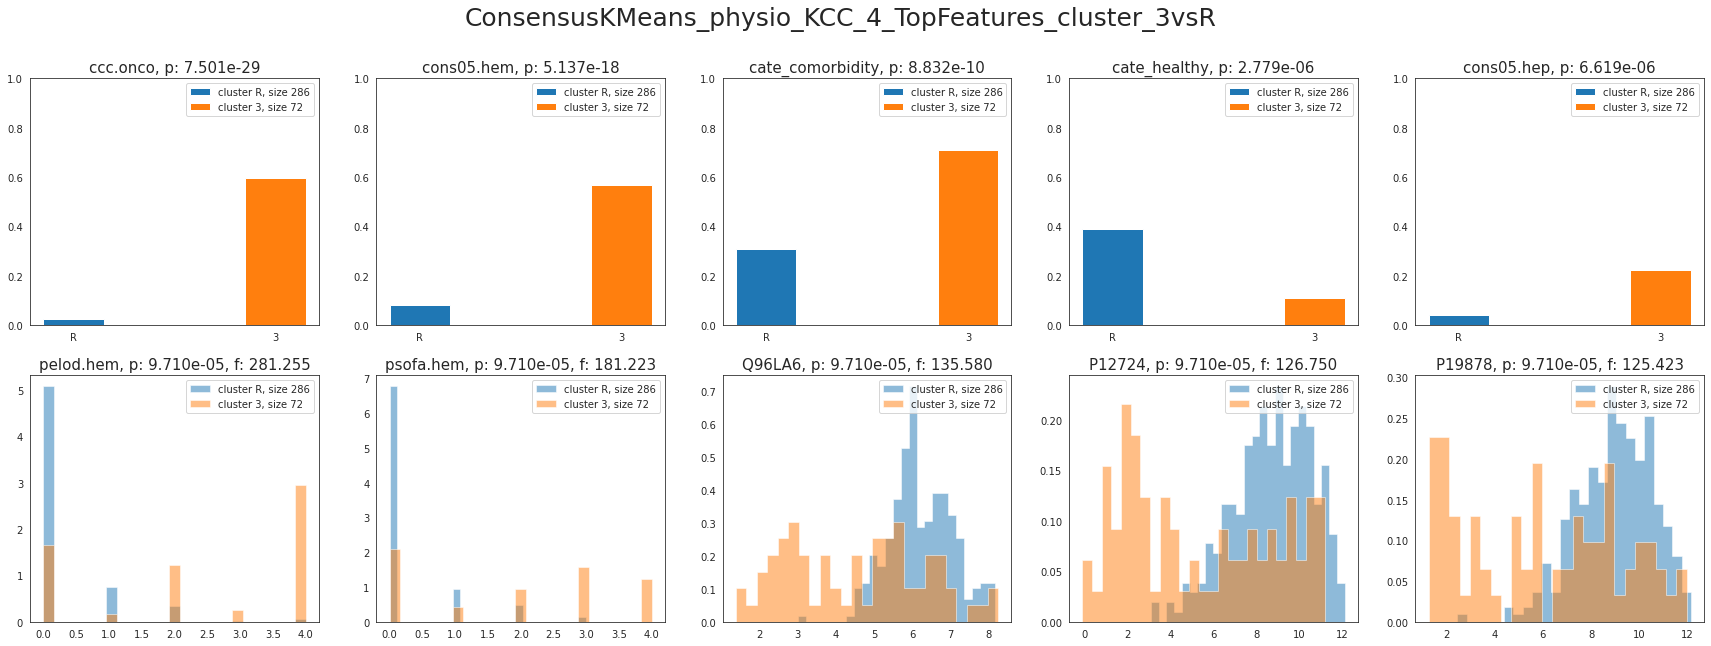

,p-value,F_stat
cons05.resp,2.189e-26,1.000e+08
ccc.neo,2.186e-20,1.000e+08
iv,5.666e-19,1.000e+08
cahai_los.hai,8.663e-19,1.000e+08
cons05.cns,2.981e-13,1.000e+08
sbp.low,9.710e-05,2.030e+02
map.low,9.710e-05,1.783e+02
sato2.low,9.710e-05,1.694e+02
context_PC_1,9.710e-05,1.659e+02
psofa.resp,9.710e-05,1.600e+02


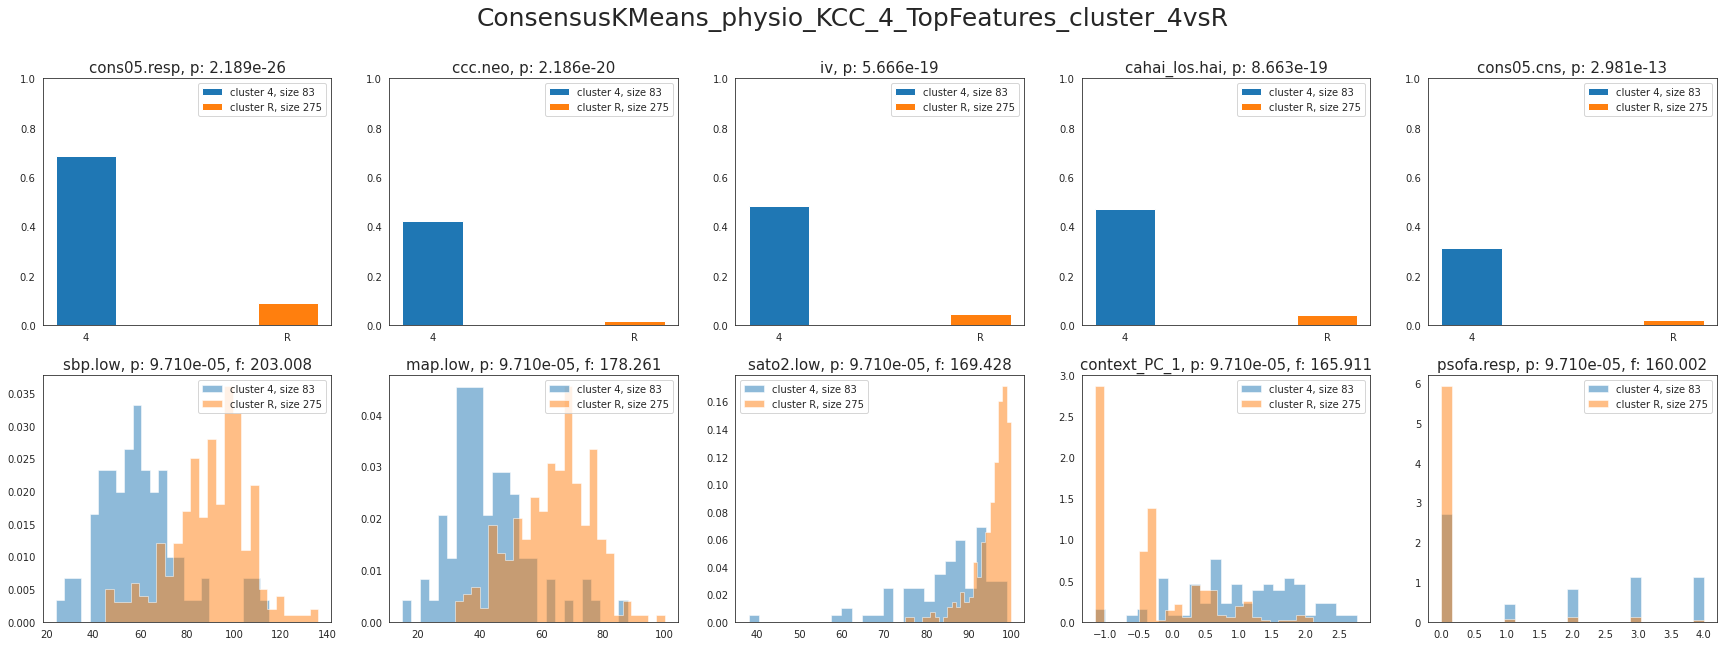

(356, 543)


,p-value,F_stat
cate_healthy,4.990e-46,1.000e+08
cahai_ca,9.119e-22,1.000e+08
cate_comorbidity,1.004e-19,1.000e+08
patho_spneumoniae,8.128e-16,1.000e+08
focus_clabsi,7.934e-15,1.000e+08
P09603,9.710e-05,1.651e+05
P52823,9.710e-05,1.234e+04
P29460,9.710e-05,1.151e+04
Q14116,9.710e-05,1.139e+04
P80162,9.710e-05,9.719e+03


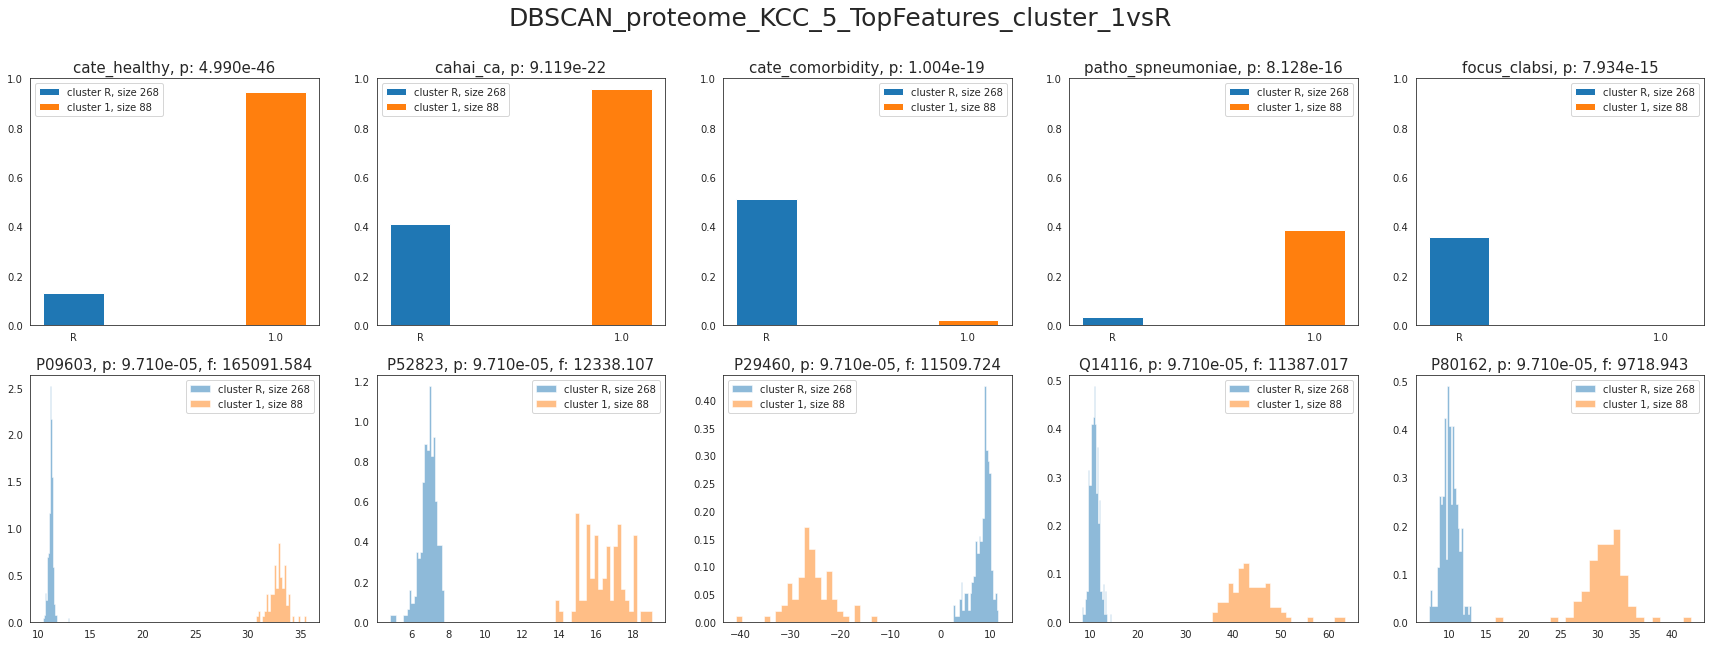

,p-value,F_stat
cate_comorbidity,1.024e-17,1.000e+08
cate_healthy,2.315e-16,1.000e+08
ccc.onco,1.001e-11,1.000e+08
patho_spneumoniae,2.486e-08,1.000e+08
focus_pneumonia,1.073e-06,1.000e+08
O00273,9.710e-05,3.938e+02
P25942,9.710e-05,3.689e+02
Q6ZUJ8,9.710e-05,3.586e+02
O95630,9.710e-05,3.535e+02
P15692,9.710e-05,3.441e+02


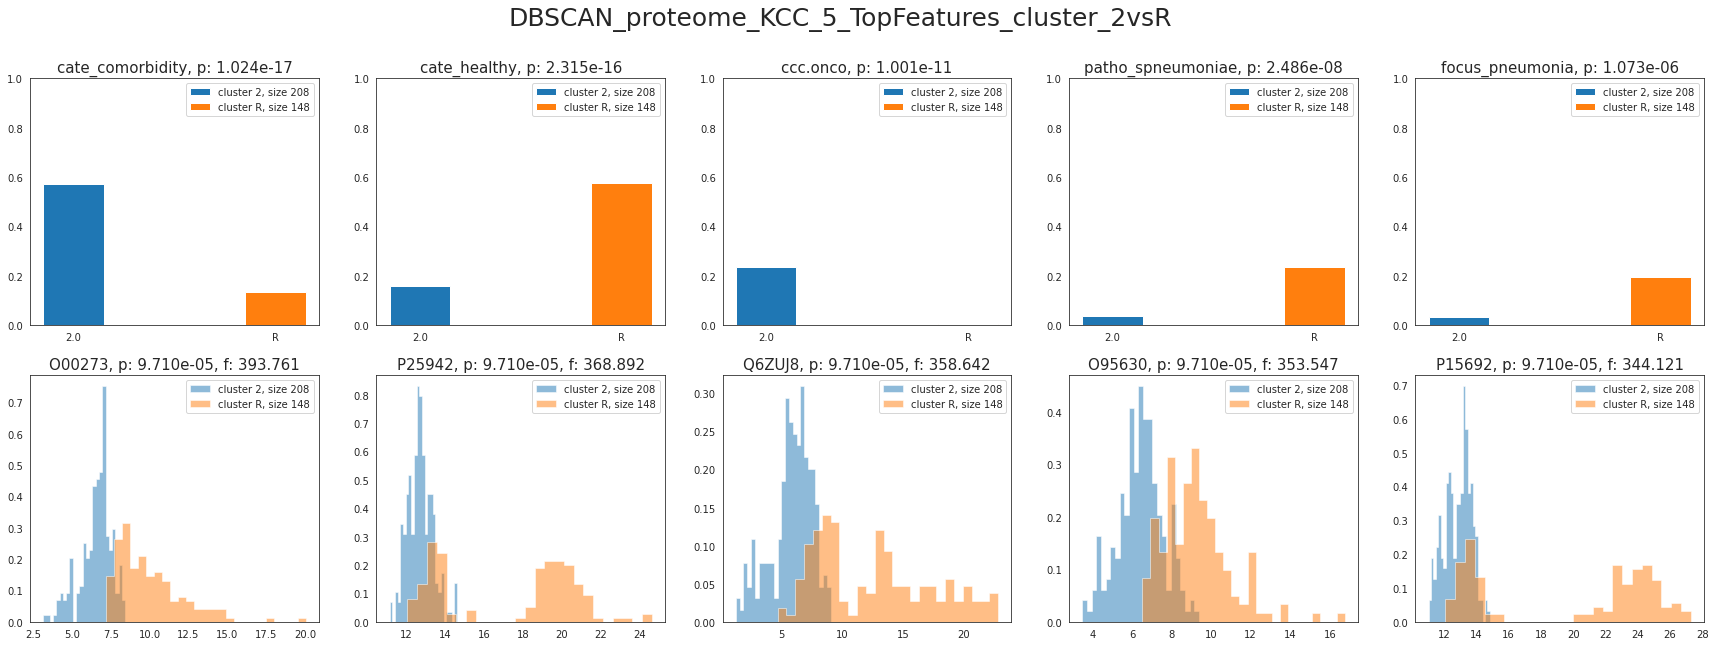

,p-value,F_stat
cahai_ca,6.649e-13,1.000e+08
cate_neonate,3.789e-12,1.000e+08
cate_healthy,2.306e-09,1.000e+08
ccc.neo,1.088e-07,1.000e+08
cons05.resp,2.926e-07,1.000e+08
Q13574,9.710e-05,2.535e+02
P40818,9.710e-05,1.779e+02
P61244,9.710e-05,1.761e+02
P98082,9.710e-05,1.697e+02
P46379,9.710e-05,1.667e+02


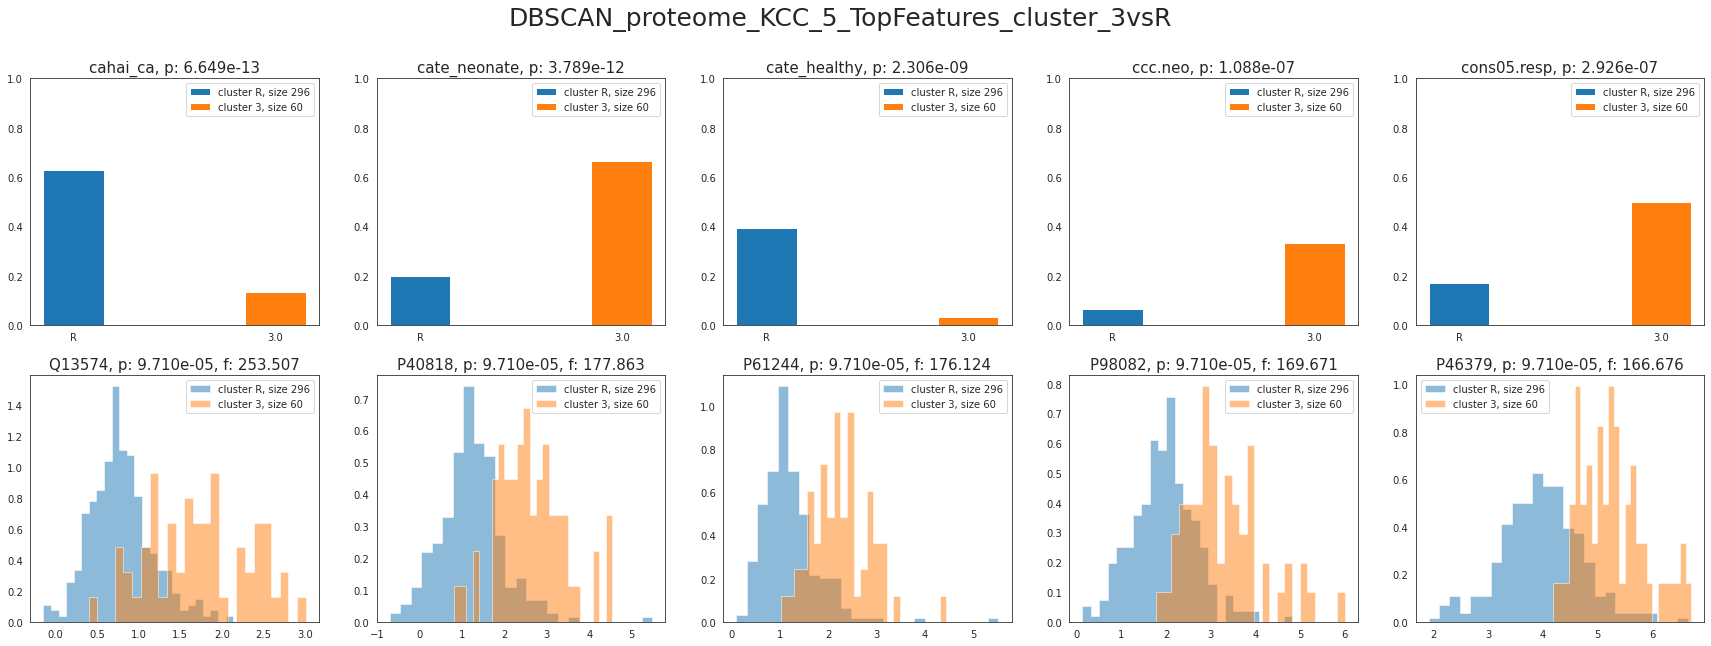

In [71]:
for i in range(len(configs)):
    view, KCC_space, method = configs[i]

    assignment = pd.read_csv(
        "{}/{}_{}_view_KCC_{}_assignments_ranked.csv".format(
            score_path, method, view, KCC_space
        ),
        index_col=0,
    )
    if method == "DBSCAN":
        assignment["assignment"] = assignment["assignment"] + 1
        assignment = assignment[assignment["assignment"] != 0]
    assignment["assignment"] = assignment["assignment"].astype(int)
    data = all_features.copy()
    data["cluster"] = assignment["assignment"]
    data = data[data["cluster"].notnull()]
    print(data.shape)
    num_cluster = len(data["cluster"].unique())
    all_clusters = sorted(data["cluster"].unique())

    for i in all_clusters:
        i =  int(i)
        data_ovr = data.copy()
        data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = 'R'
        
        fig_name = "{}_{}_KCC_{}_TopFeatures_cluster_{}vsR".format(
            method, view, KCC_space, i
        )
        fstat_name = "{}_{}_KCC_{}_F_stat_cluster_{}vsR.csv".format(
                    method, view, KCC_space, i
                )
        F_stat = pd.read_csv(
            "{}/{}".format(f_stat_path, fstat_name), index_col=0
        )
        fisher_name = "{}_{}_KCC_{}_FisherExact_cluster_{}vsR.csv".format(method, view, KCC_space, i)
        Fisher = pd.read_csv(
            "{}/{}".format(f_stat_path, fisher_name), index_col=0
        )
        Fisher.columns = ["p-value"]
        Fisher["F_stat"] = np.nan
        
        F_stat = F_stat[F_stat["p-value"] < 0.05]
        #Fisher = Fisher[Fisher["p-value"] < 0.05 / total_vars]
        Fisher['F_stat'] = 1e8

        Fisher = Fisher.sort_values('p-value').iloc[:5]
        F_stat = F_stat.sort_values('F_stat', ascending=False).iloc[:5]
        stat = pd.concat([Fisher, F_stat])
        display(stat)
        plot_top(
            data_ovr, stat, top_feature_plot_path, fig_name
        )

,p-value,F_stat
ccc.onco,1.966e-15,1.000e+08
cate_comorbidity,1.761e-12,1.000e+08
cons05.hem,2.672e-10,1.000e+08
patho_viridansgroup,2.101e-05,1.000e+08
cate_healthy,2.179e-05,1.000e+08
Q07011,9.710e-05,1.530e+02
P35237,9.710e-05,1.523e+02
P80303,9.710e-05,1.520e+02
Q92520,9.710e-05,1.518e+02
P01137,9.710e-05,1.354e+02


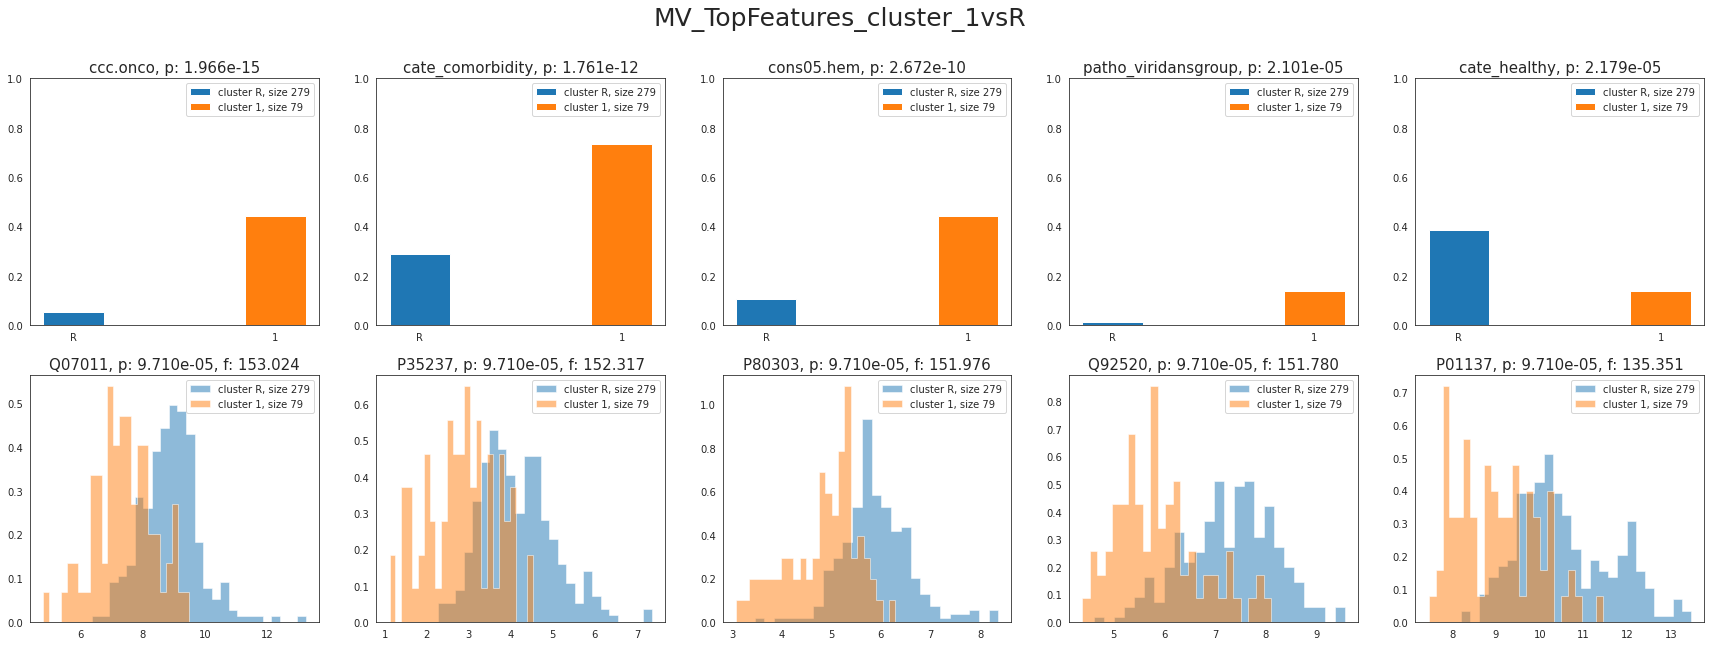

,p-value,F_stat
cate_healthy,2.470e-07,1.000e+08
cahai_ca,7.739e-06,1.000e+08
ccc.surg,6.108e-04,1.000e+08
cahai_eos,2.228e-03,1.000e+08
cahai_hai,4.716e-03,1.000e+08
Q13574,9.710e-05,1.968e+02
P49023,9.710e-05,1.425e+02
P50749,9.710e-05,1.356e+02
P55957,9.710e-05,1.356e+02
Q9C035,9.710e-05,1.281e+02


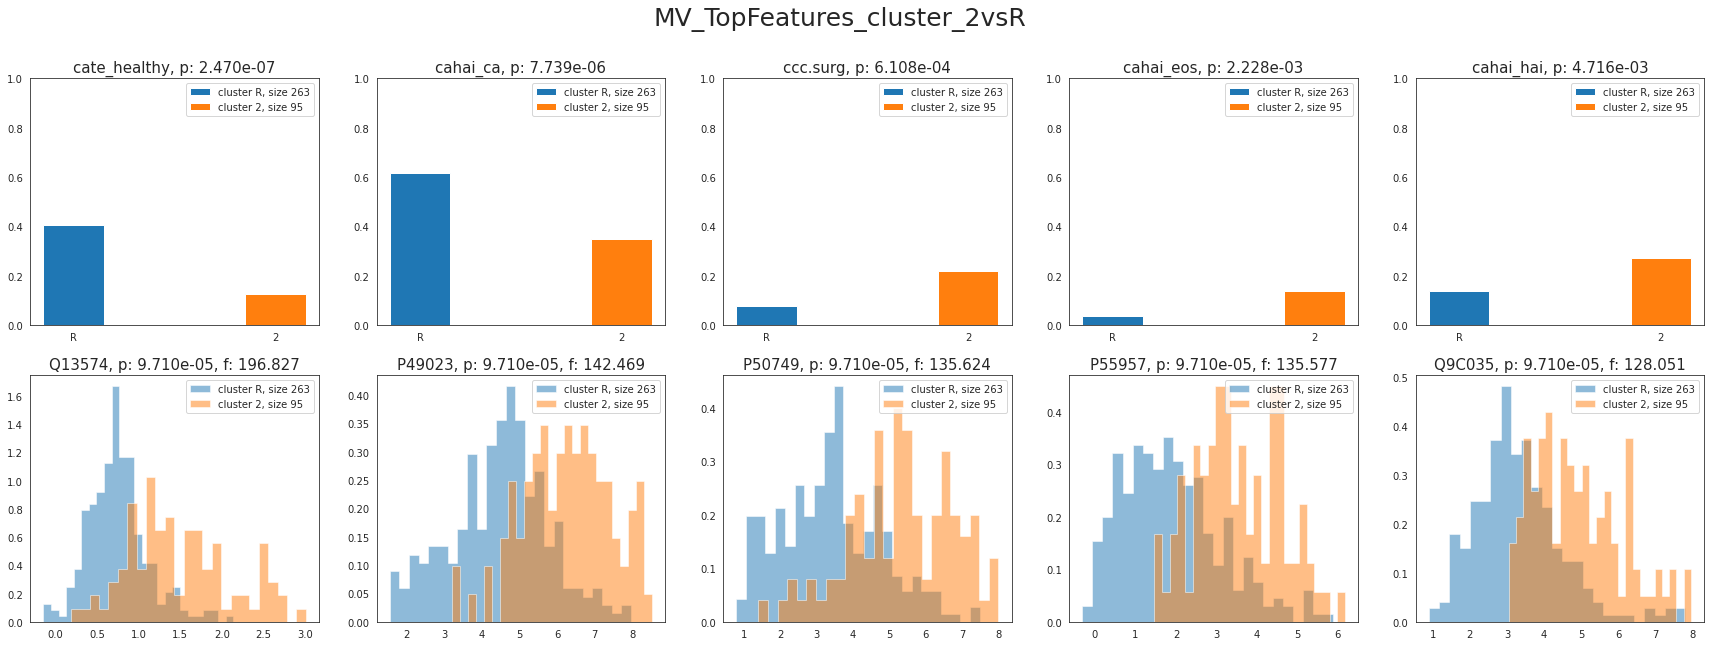

,p-value,F_stat
cate_healthy,4.466e-44,1.000e+08
cahai_ca,2.983e-21,1.000e+08
cate_comorbidity,6.211e-19,1.000e+08
patho_spneumoniae,4.570e-15,1.000e+08
focus_clabsi,3.334e-14,1.000e+08
P09603,9.710e-05,1.247e+04
P52823,9.710e-05,7.625e+03
Q14116,9.710e-05,7.358e+03
P29460,9.710e-05,7.118e+03
P80162,9.710e-05,6.234e+03


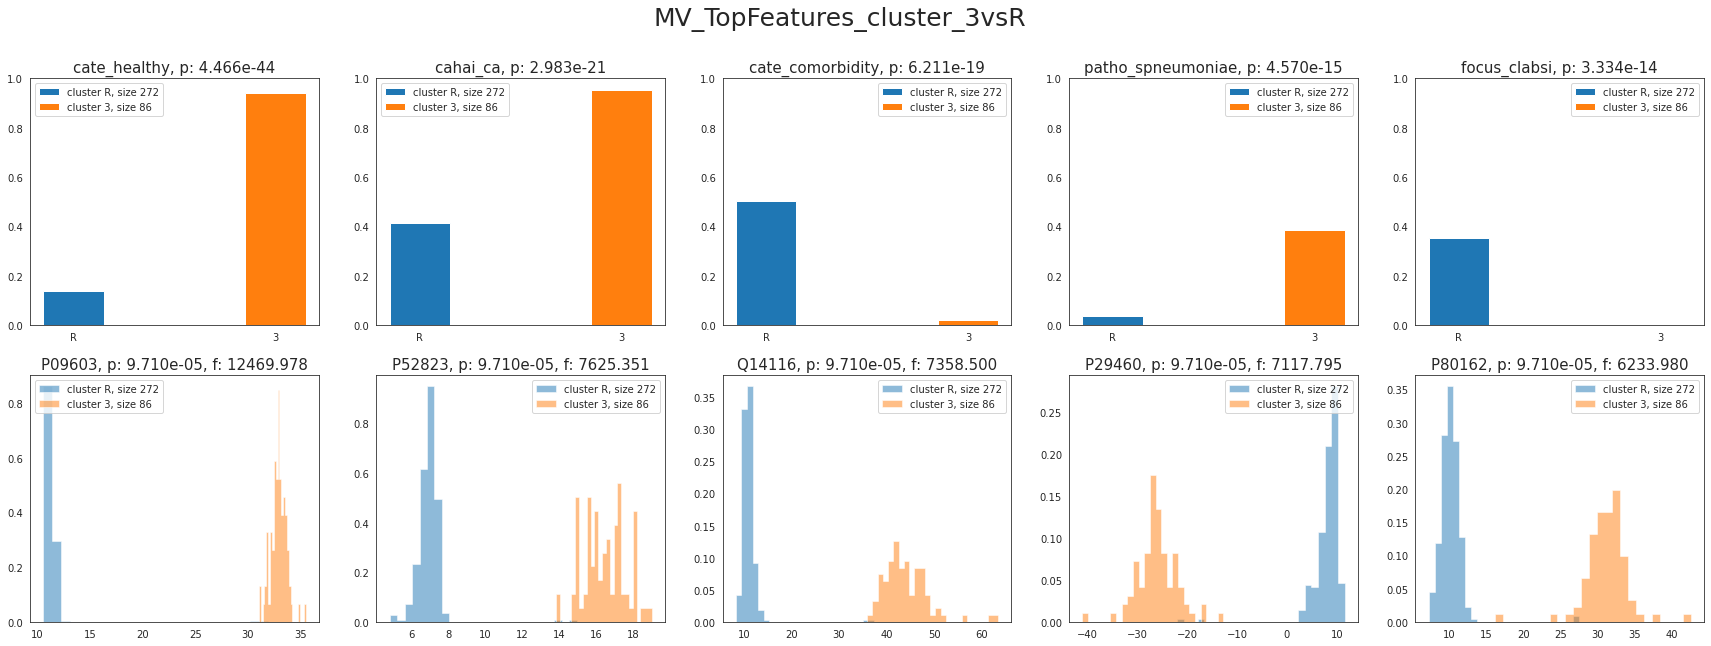

,p-value,F_stat
cahai_los.hai,1.986e-10,1.000e+08
cate_neonate,2.234e-09,1.000e+08
cahai_ca,7.138e-09,1.000e+08
ccc.neo,1.887e-08,1.000e+08
cate_healthy,5.165e-06,1.000e+08
Q9P0M4,9.710e-05,1.274e+02
P28325,9.710e-05,1.140e+02
Q9H6B4,9.710e-05,1.072e+02
Q86VZ4,9.710e-05,1.010e+02
Q641Q3,9.710e-05,9.155e+01


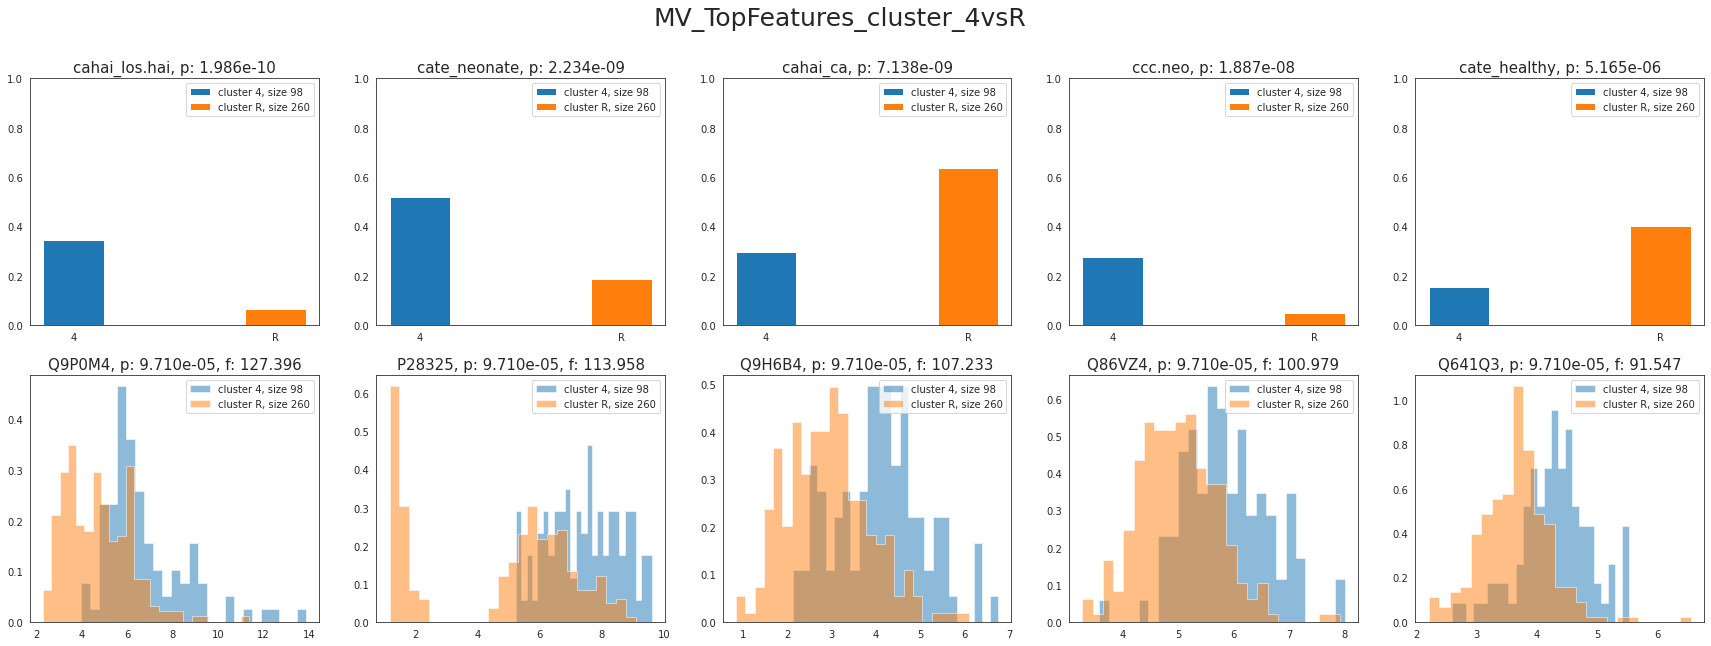

In [72]:
assignment = pd.read_csv(
        "{}/MVKDR_results/proteome_clinical_K_4_assignments_ranked.csv".format(data_path),
        index_col=0,
    )
data = all_features.copy()
data["cluster"] = assignment["assignment"]
data = data[data["cluster"].notnull()]
num_cluster = len(data["cluster"].unique())
all_clusters = sorted(data["cluster"].unique())
for i in all_clusters:
    i =  int(i)
    data_ovr = data.copy()
    data_ovr.loc[data[data['cluster'] != i].index, 'cluster'] = 'R'

    fig_name = "MV_TopFeatures_cluster_{}vsR".format(
        i
    )
    fstat_name = "MV_F_stat_cluster_{}vsR.csv".format(i)
    
    F_stat = pd.read_csv(
        "{}/{}".format(f_stat_path, fstat_name), index_col=0
    )

    fisher_name = "MV_FisherExact_cluster_{}vsR.csv".format(i)
    Fisher = pd.read_csv(
        "{}/{}".format(f_stat_path, fisher_name), index_col=0
    )
    Fisher.columns = ["p-value"]
    Fisher["F_stat"] = np.nan

    F_stat = F_stat[F_stat["p-value"] < 0.05]
    #Fisher = Fisher[Fisher["p-value"] < 0.05 /total_vars]
    Fisher['F_stat'] = 1e8
    
    Fisher = Fisher.sort_values('p-value').iloc[:5]
    F_stat = F_stat.sort_values('F_stat', ascending=False).iloc[:5]
    stat = pd.concat([Fisher, F_stat])
    display(stat)

    plot_top(
        data_ovr, stat, top_feature_plot_path, fig_name
    )